### Библиотеки

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format='retina'
sns.set_style("darkgrid")

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../data')

from plotly.offline import iplot
from plotly import graph_objs as go

from sklearn.metrics import mean_squared_error, mean_absolute_error

from scipy.optimize import minimize

### Данные

In [2]:
df = pd.read_csv("../data/dataset.csv")
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.set_index('Timestamp')
dataset = df[['Income', 'Outcome', 'Balance']][df.index.year >= 2020]

In [3]:
def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

In [4]:
plotly_df(dataset, 'Raw data')

### Скользящие методы

#### Скользящее среднее

In [5]:
def plotMovingAverage(series, n):
    
    """
    series - dataframe with timeseries
    n - rolling window size 
    
    """
    
    rolling_mean = series.rolling(window=n).mean().shift(1)
    rolling_std =  series.rolling(window=n).std().shift(1)
    upper_bond = rolling_mean+1.96*rolling_std
    lower_bond = rolling_mean-1.96*rolling_std
    
    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")
    
    plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    plt.plot(lower_bond, "r--")
    plt.plot(series[n+1:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

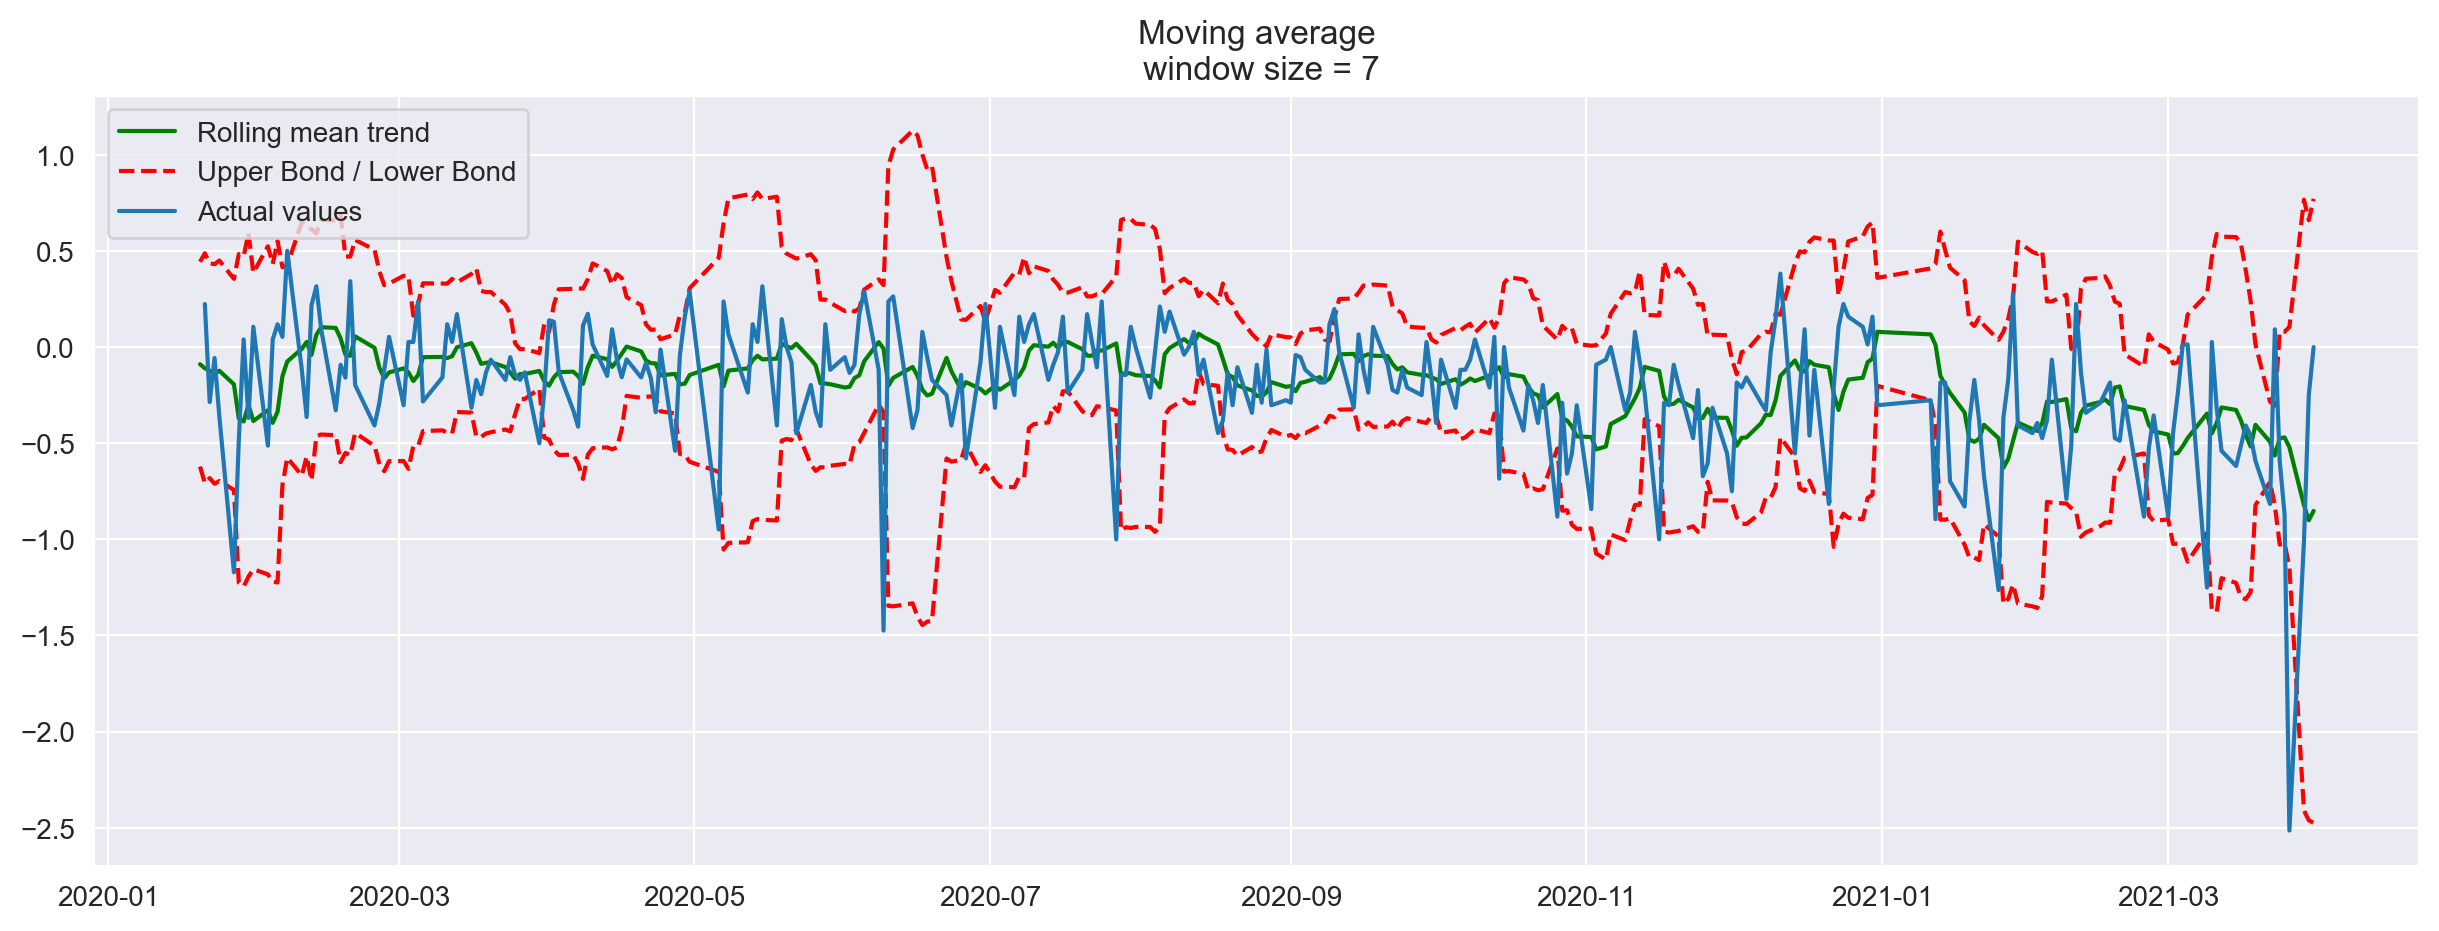

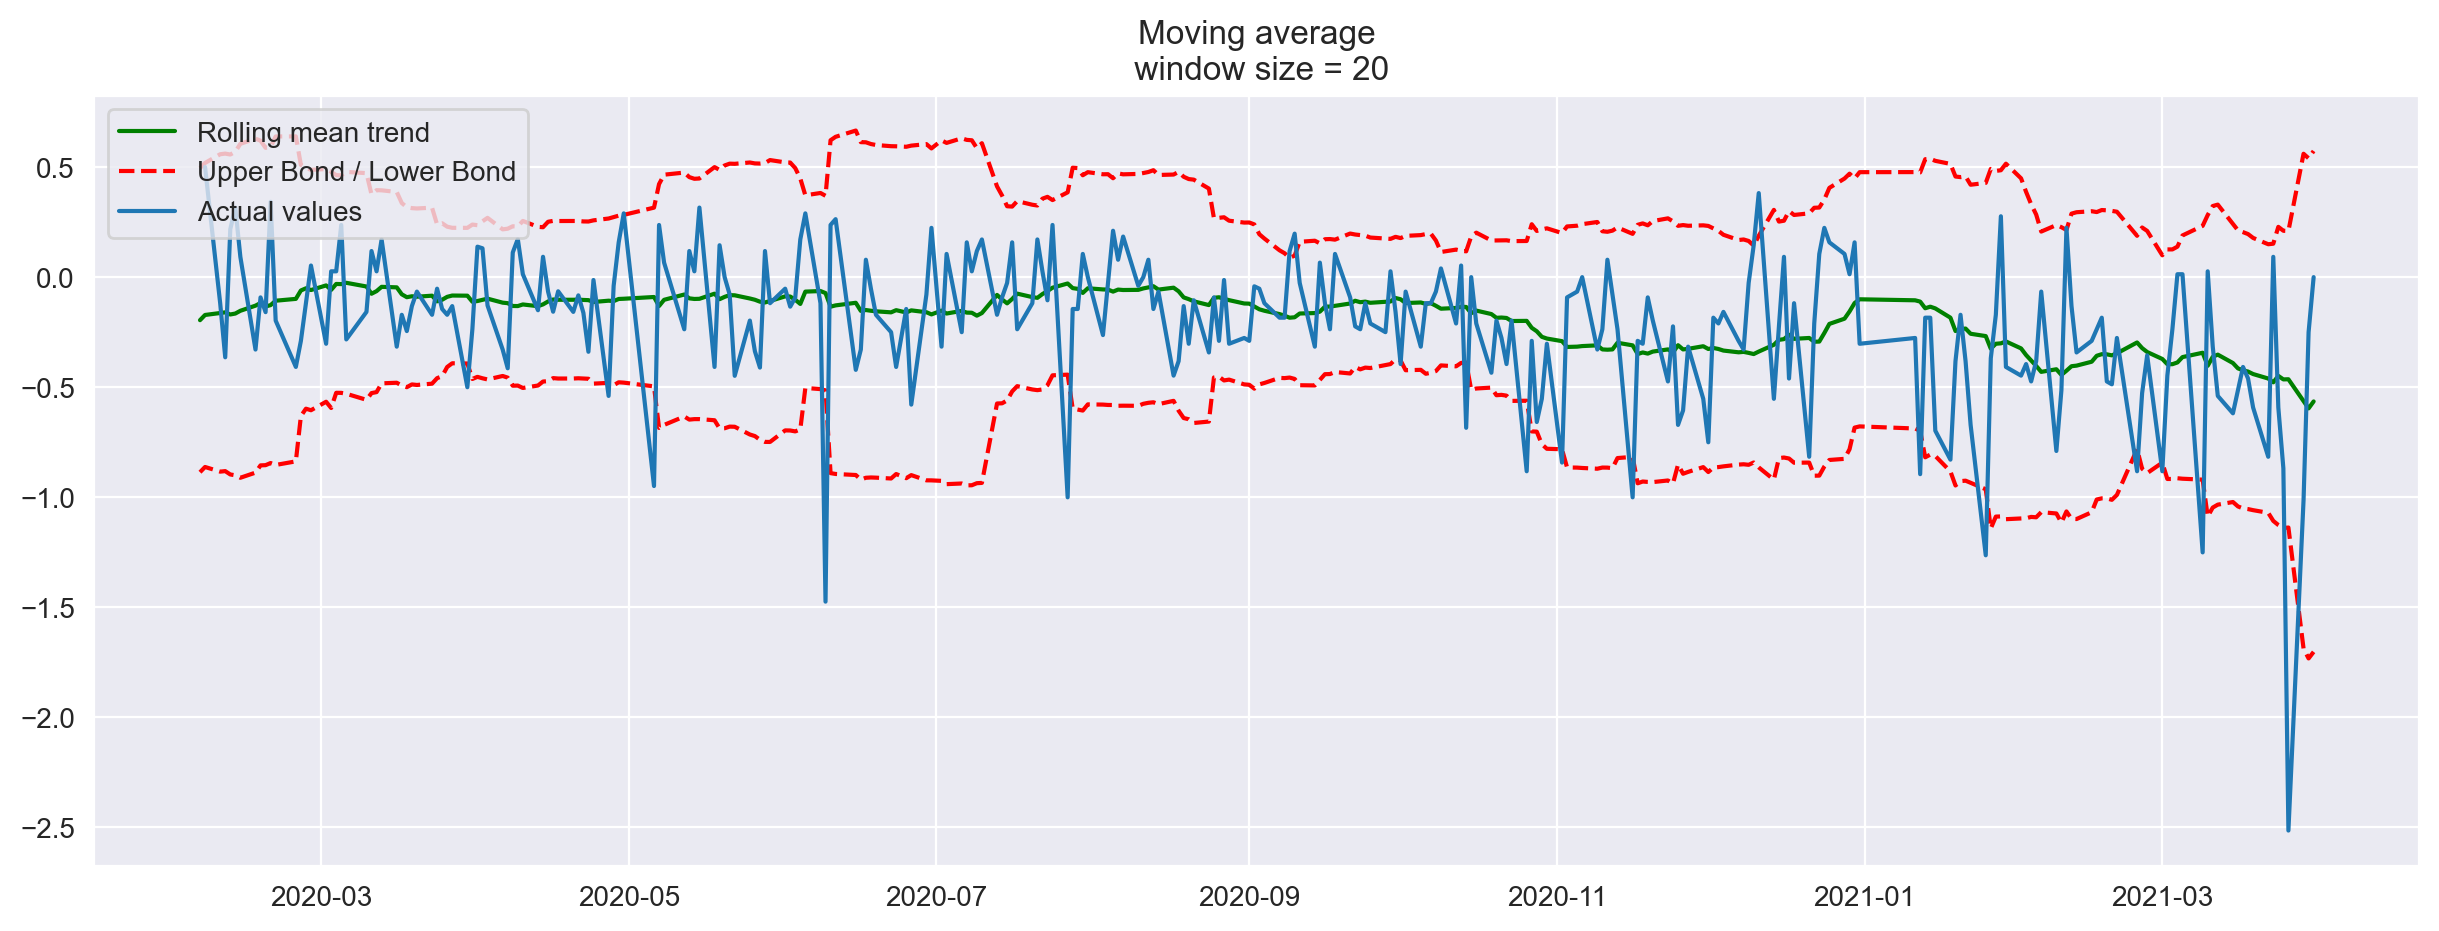

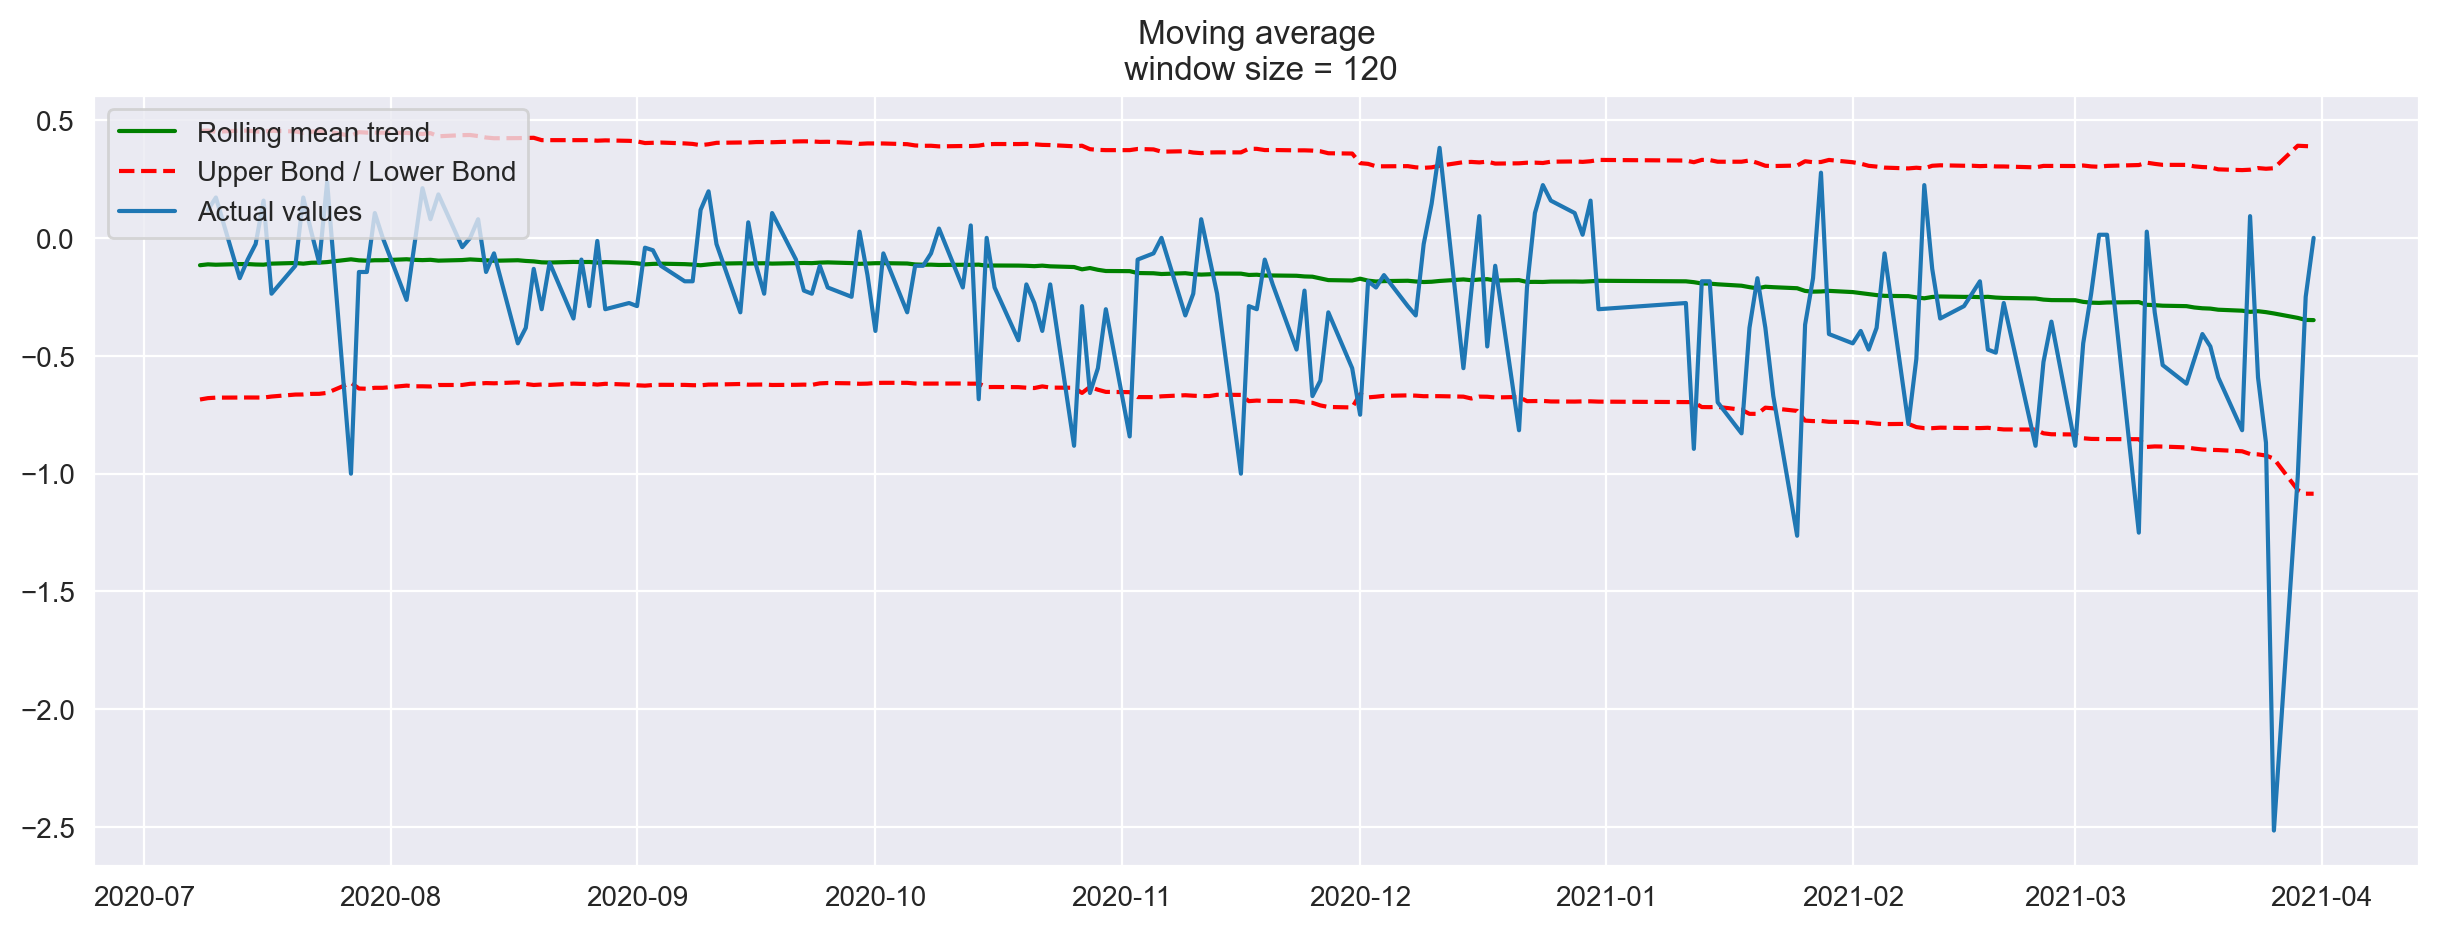

In [6]:
plotMovingAverage(dataset['Balance'], 7) # сглаживаем по неделям
plotMovingAverage(dataset['Balance'], 20) # сглаживаем по месяцам
plotMovingAverage(dataset['Balance'], 120) # сглаживаем по 3 месяцам

#### Экспоненциальное сглаживание

In [7]:
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)-1):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return [np.nan]+result

In [8]:
alpha1 = 0.6
alpha2 = 0.05
df = pd.concat([dataset['Balance'],
                pd.DataFrame(exponential_smoothing(dataset['Balance'], alpha1), index=dataset.index), 
                pd.DataFrame(exponential_smoothing(dataset['Balance'], alpha2), index=dataset.index)], axis=1)
df.columns=['Actual', 'Alpha = ' + str(alpha1), 'Alpha = ' + str(alpha2)]

In [9]:
plotly_df(df, title = "Exponential Smooting")

#### Двойное экспоненциальное сглаживание

In [10]:
def double_exponential_smoothing(series, alpha, beta):
    level, trend = series[0], 0
    result = [level + trend]
    for n in range(1, len(series)-1):
        last_level, level = level, alpha*series[n] + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append((level+trend))
    return [np.nan]+result

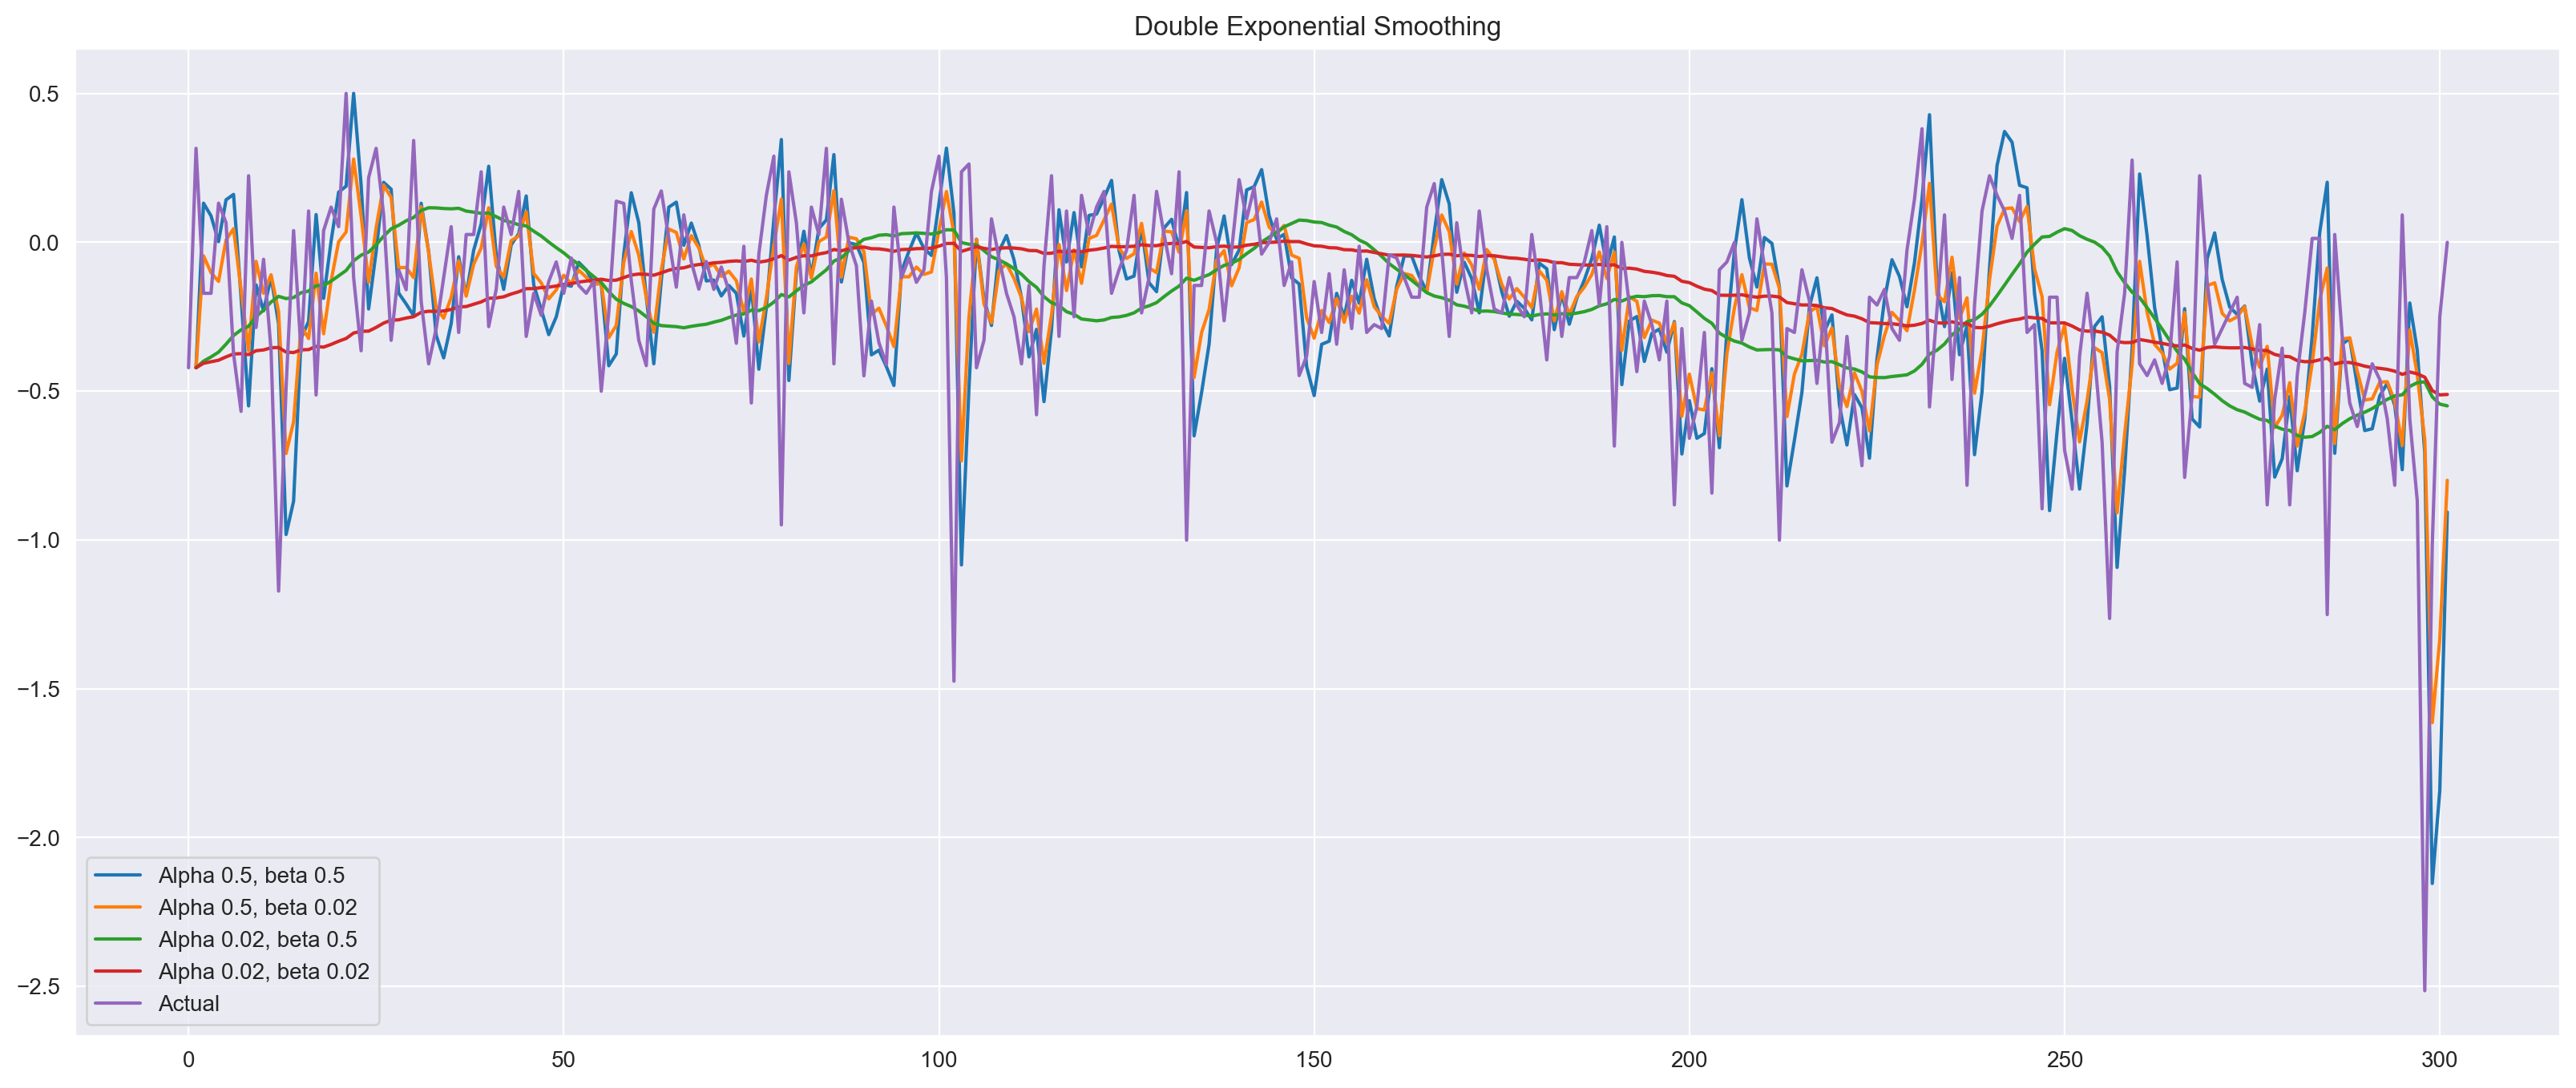

In [11]:
plt.figure(figsize=(20, 8))
for alpha in [0.5, 0.02]:
    for beta in [0.5, 0.02]:
        plt.plot(double_exponential_smoothing(dataset['Balance'], alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
plt.plot(dataset['Balance'].values, label = "Actual")
plt.legend(loc="best")
plt.axis('tight')
plt.title("Double Exponential Smoothing")
plt.grid(True)

#### Считаем ошибку

In [25]:
df = pd.concat([pd.DataFrame(dataset['Balance']),
                pd.DataFrame(exponential_smoothing(dataset['Balance'], 0.4), index=dataset.index),
                pd.DataFrame(double_exponential_smoothing(dataset['Balance'], 0.7, 0.4), index=dataset.index)], axis=1)
df.columns=['Actual', 'Smoothing', 'Double Smoothing']
plotly_df(df, title='Сравнение двух методов')

In [26]:
df

Actual  Smoothing  Double Smoothing
Timestamp                                        
2020-01-09 -0.421342        NaN               NaN
2020-01-10  0.316007  -0.421342         -0.421342
2020-01-13 -0.171170  -0.126403          0.301260
2020-01-14 -0.171170  -0.144310          0.044736
2020-01-15  0.131669  -0.155054         -0.092675
...              ...        ...               ...
2021-03-25 -0.869018  -0.443703         -0.415959
2021-03-26 -2.514887  -0.613829         -0.854403
2021-03-29 -1.013855  -1.374252         -2.602980
2021-03-30 -0.250172  -1.230093         -1.631875
2021-03-31  0.000000  -0.838125         -0.419089

[302 rows x 3 columns]

In [27]:
roll_days=10
mae_smooting=np.abs(df['Actual']-df['Smoothing']).rolling(roll_days).mean().dropna()
mae_double_smooting=np.abs(df['Actual']-df['Double Smoothing']).rolling(roll_days).mean().dropna()

df_mae = pd.concat([mae_smooting, mae_double_smooting], axis=1)
df_mae.columns = ['MAE_SMOTHING', 'MAE_DOUBLE_SMOOTING']
plotly_df(df_mae, title='Скользящее MAE')

#### Тройное экспоненциальное сглаживание (известное также как модель Хольта-Винтерса)

In [28]:
class HoltWinters:
    
    """
    Модель Хольта-Винтерса с методом Брутлага для детектирования аномалий
    https://fedcsis.org/proceedings/2012/pliks/118.pdf
    
    
    # series - исходный временной ряд
    # slen - длина сезона
    # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса
    # n_preds - горизонт предсказаний
    # scaling_factor - задаёт ширину доверительного интервала по Брутлагу (обычно принимает значения от 2 до 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        summ = 0.0
        for i in range(self.slen):
            summ += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return summ / self.slen
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                
                
                continue
            if i >= len(self.series): # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                
            
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])


            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])
                
                
                
            
            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])  

In [29]:
from sklearn.model_selection import TimeSeriesSplit
SLEN = 20

def timeseriesCVscore(x, data):
    # вектор ошибок
    errors = []
    
    values = data.values
    alpha, beta, gamma = x
    
    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen = SLEN, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)
    return np.mean(np.array(errors))

In [30]:
dataset

Income   Outcome   Balance
Timestamp                               
2020-01-09  1.843372  2.264715 -0.421342
2020-01-10  1.803872  1.487865  0.316007
2020-01-13  1.685369  1.856539 -0.171170
2020-01-14  1.566867  1.738037 -0.171170
2020-01-15  1.672202  1.540533  0.131669
...              ...       ...       ...
2021-03-25  2.304215  3.173234 -0.869018
2021-03-26  2.172546  4.687433 -2.514887
2021-03-29  2.356883  3.370738 -1.013855
2021-03-30  2.317382  2.567554 -0.250172
2021-03-31  2.528054  2.528054  0.000000

[302 rows x 3 columns]

In [31]:
train_data = dataset['Balance'].iloc[:250]
test_data = dataset['Balance'].iloc[250:]


x = [0, 0, 0] 
opt = minimize(timeseriesCVscore, x0=x, args=(train_data), method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))

alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

0.054312500253493434 0.05759558146752408 0.2079173244576767


In [32]:
model = HoltWinters(test_data[:-1], slen = SLEN, alpha = alpha_final, beta = beta_final, gamma = gamma_final, n_preds = 1, scaling_factor = 2.56)
model.triple_exponential_smoothing()

In [33]:
df_holt = pd.concat([pd.DataFrame(test_data.values, index=test_data.index),
                     pd.DataFrame(model.result, index=test_data.index)], axis=1)
df_holt.columns=['Actual', 'HoltWinters']

In [34]:
plotly_df(df_holt, title='HoltWinters')

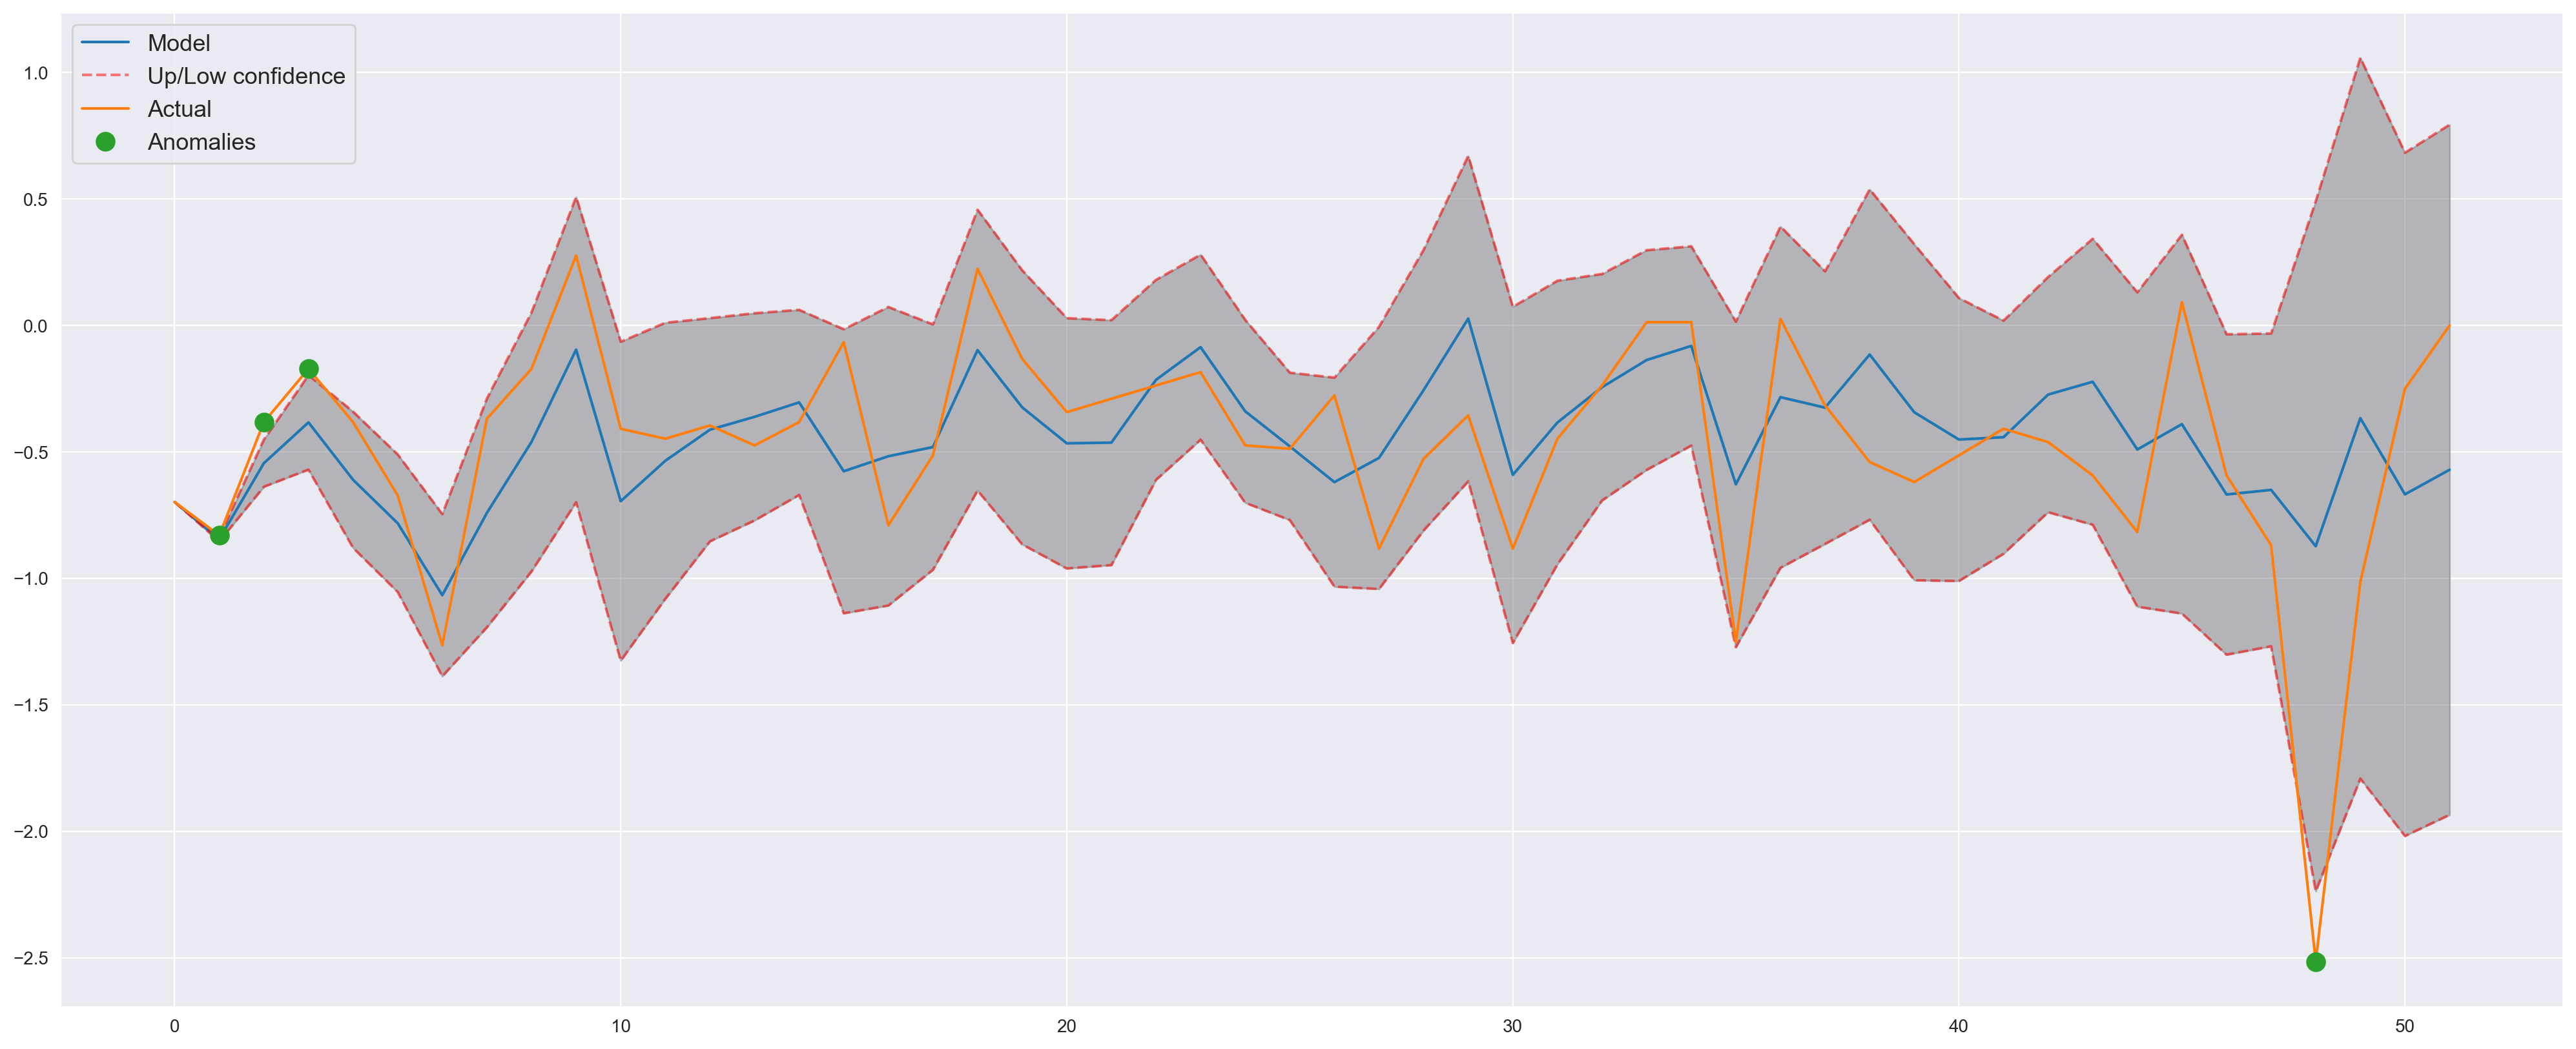

In [35]:
def plotHoltWinters(data):
    Anomalies = np.array([np.nan]*len(data))
    Anomalies[data.values<model.LowerBond] = data.values[data.values<model.LowerBond]
    Anomalies[data.values>model.UpperBond] = data.values[data.values>model.UpperBond]
    plt.figure(figsize=(25, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
    plt.plot(model.LowerBond, "r--", alpha=0.5)
    plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, y2=model.LowerBond, alpha=0.5, color = "grey")
    plt.plot(data.values, label = "Actual")
    plt.plot(Anomalies, "o", markersize=10, label = "Anomalies")
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13)

plotHoltWinters(test_data)

In [36]:
df = df.iloc[-len(test_data):]
df['Triple Smoothing'] = model.result
mae_smooting=np.abs(df['Actual']-df['Smoothing'])
mae_double_smooting=np.abs(df['Actual']-df['Double Smoothing'])
mae_triple_smooting=np.abs(df['Actual']-df['Triple Smoothing'])

df_mae = pd.concat([mae_smooting, mae_double_smooting, mae_triple_smooting], axis=1)
df_mae.columns = ['MAE_SMOTHING', 'MAE_DOUBLE_SMOOTING', 'MAE_TRIPLE_SMOOTHING']
plotly_df(df_mae, title='MAE')

In [37]:
df_mae.mean(axis=0)

MAE_SMOTHING            0.341849
MAE_DOUBLE_SMOOTING     0.442032
MAE_TRIPLE_SMOOTHING    0.251342
dtype: float64

### Feature Exctractor

In [210]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [255]:
df = pd.read_csv("../data/dataset.csv")
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.set_index('Timestamp')
dataset = df.copy()

In [256]:
dataset['month'] = dataset.index.month

lags = list(range(1, 2))
for l in lags:
    dataset[f'lag_income_{l}'] = dataset['Income'].shift(l)
    dataset[f'lag_outcome_{l}'] = dataset['Outcome'].shift(l)

windows = [3, 7, 14]
for window in windows:
    dataset[f'rolling_mean_{window}'] = dataset['Balance'].shift(1).rolling(window).mean()
    dataset[f'rolling_std_{window}'] = dataset['Balance'].shift(1).rolling(window).std()

dataset['rate_diff'] = dataset['rate_russ'] - dataset['rate_usa']

day_data = pd.get_dummies(dataset['week_day'], prefix='week_day').astype(int)
month_data = pd.get_dummies(dataset['month'], prefix='month').astype(int)

dataset = pd.concat([dataset, day_data, month_data], axis=1)

dataset = dataset.dropna()
dataset = dataset.drop(columns=['Date', 'week_day_name', 'is_holiday', "Income", "Outcome", 'target_inflation', 'real_inflation', 'rate_russ', 'rate_usa', 'week_day', 'month'], axis=1)

<Axes: >

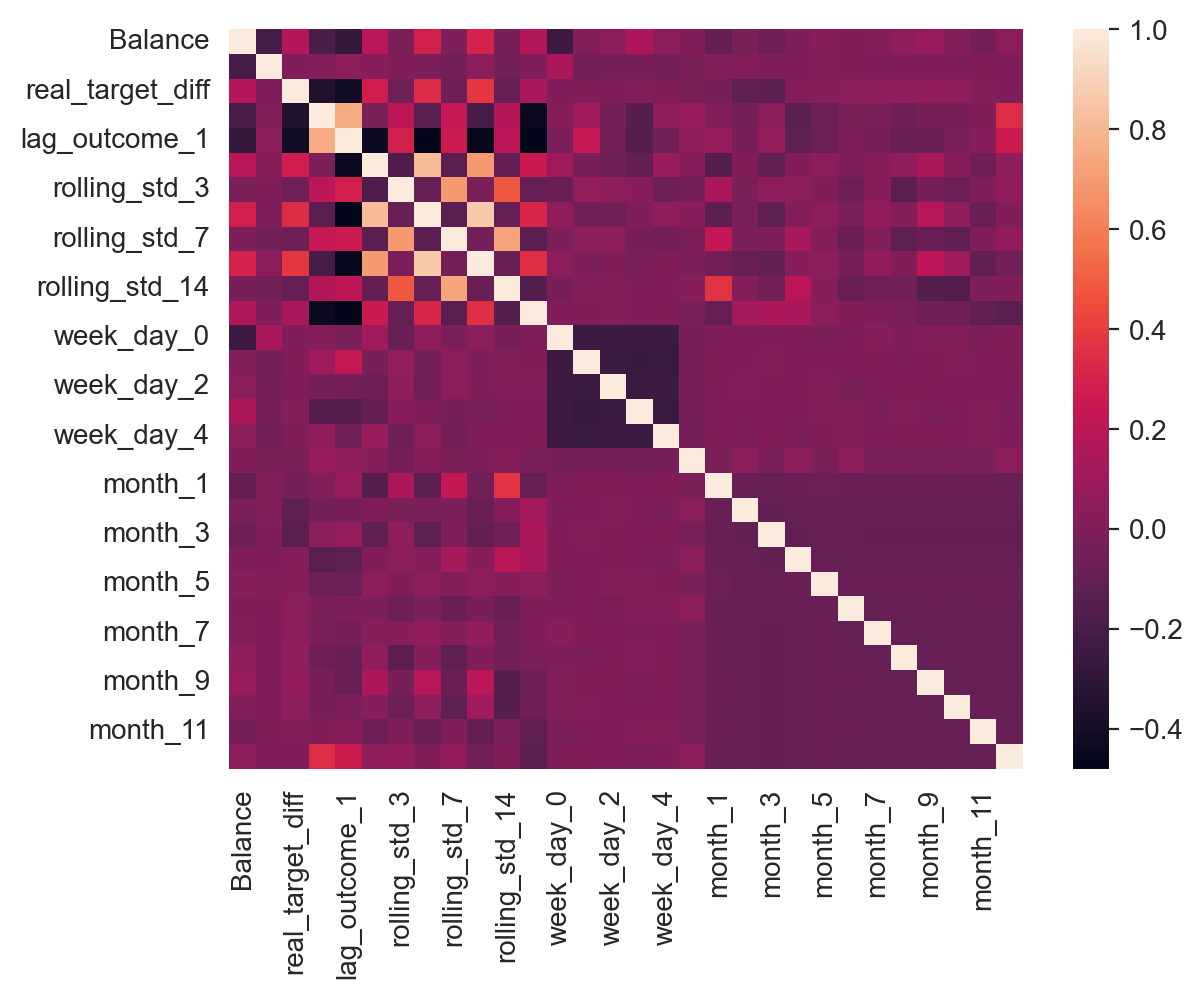

In [257]:
sns.heatmap(dataset.corr())

In [258]:
#df.to_csv("../data/features_df.csv")

In [259]:
test_size = 0.2
#dataset = dataset[dataset.index.year >= 2020]
test_index = int(len(dataset)*(1-test_size))
dataset = dataset.reset_index(drop=True)

X_train = dataset.loc[:test_index].drop(["Balance"], axis=1)
y_train = dataset.loc[:test_index]["Balance"]
X_test = dataset.loc[test_index:].drop(["Balance"], axis=1)
y_test = dataset.loc[test_index:]["Balance"]

In [260]:
dataset

Balance  tax_day  real_target_diff  lag_income_1  lag_outcome_1  \
0    -0.199300        0              -0.6      0.978296       1.112359   
1    -0.157799        0              -0.6      1.196396       1.395696   
2    -0.027000        0              -0.6      1.303732       1.461531   
3     0.093309        0              -0.6      1.260402       1.287402   
4     0.083316        0              -0.3      0.953503       0.860194   
...        ...      ...               ...           ...            ...   
1022 -0.869018        1              -1.5      1.935541       2.528054   
1023 -2.514887        0              -1.5      2.304215       3.173234   
1024 -1.013855        0              -1.5      2.172546       4.687433   
1025 -0.250172        0              -1.5      2.356883       3.370738   
1026  0.000000        0              -1.5      2.317382       2.567554   

      rolling_mean_3  rolling_std_3  rolling_mean_7  rolling_std_7  \
0          -0.058150       0.114356       -0.075413       0.078553   
1          -0.149042       0.044693       -0.086055       0.090498   
2          -0.163721       0.033019       -0.107828       0.086083   
3          -0.128033       0.089924       -0.095414       0.091177   
4          -0.030497       0.125590       -0.066463       0.115061   
...              ...            ...             ...            ...   
1022       -0.438898       0.473339       -0.470248       0.280419   
1023       -0.456454       0.494827       -0.521035       0.319087   
1024       -1.325473       1.039299       -0.821994       0.810306   
1025       -1.465920       0.911314       -0.900995       0.796060   
1026       -1.259638       1.152189       -0.852089       0.828043   

      rolling_mean_14  ...  month_3  month_4  month_5  month_6  month_7  \
0           -0.036247  ...        0        0        0        0        0   
1           -0.040138  ...        0        0        0        0        0   
2           -0.042439  ...        0        0        0        0        0   
3           -0.044923  ...        0        0        0        0        0   
4           -0.095174  ...        0        0        0        0        0   
...               ...  ...      ...      ...      ...      ...      ...   
1022        -0.426045  ...        1        0        0        0        0   
1023        -0.489058  ...        1        0        0        0        0   
1024        -0.669633  ...        1        0        0        0        0   
1025        -0.652704  ...        1        0        0        0        0   
1026        -0.672455  ...        1        0        0        0        0   

      month_8  month_9  month_10  month_11  month_12  
0           0        0         0         0         0  
1           0        0         0         0         0  
2           0        0         0         0         0  
3           0        0         0         0         0  
4           0        0         0         0         0  
...       ...      ...       ...       ...       ...  
1022        0        0         0         0         0  
1023        0        0         0         0         0  
1024        0        0         0         0         0  
1025        0        0         0         0         0  
1026        0        0         0         0         0  

[1027 rows x 30 columns]

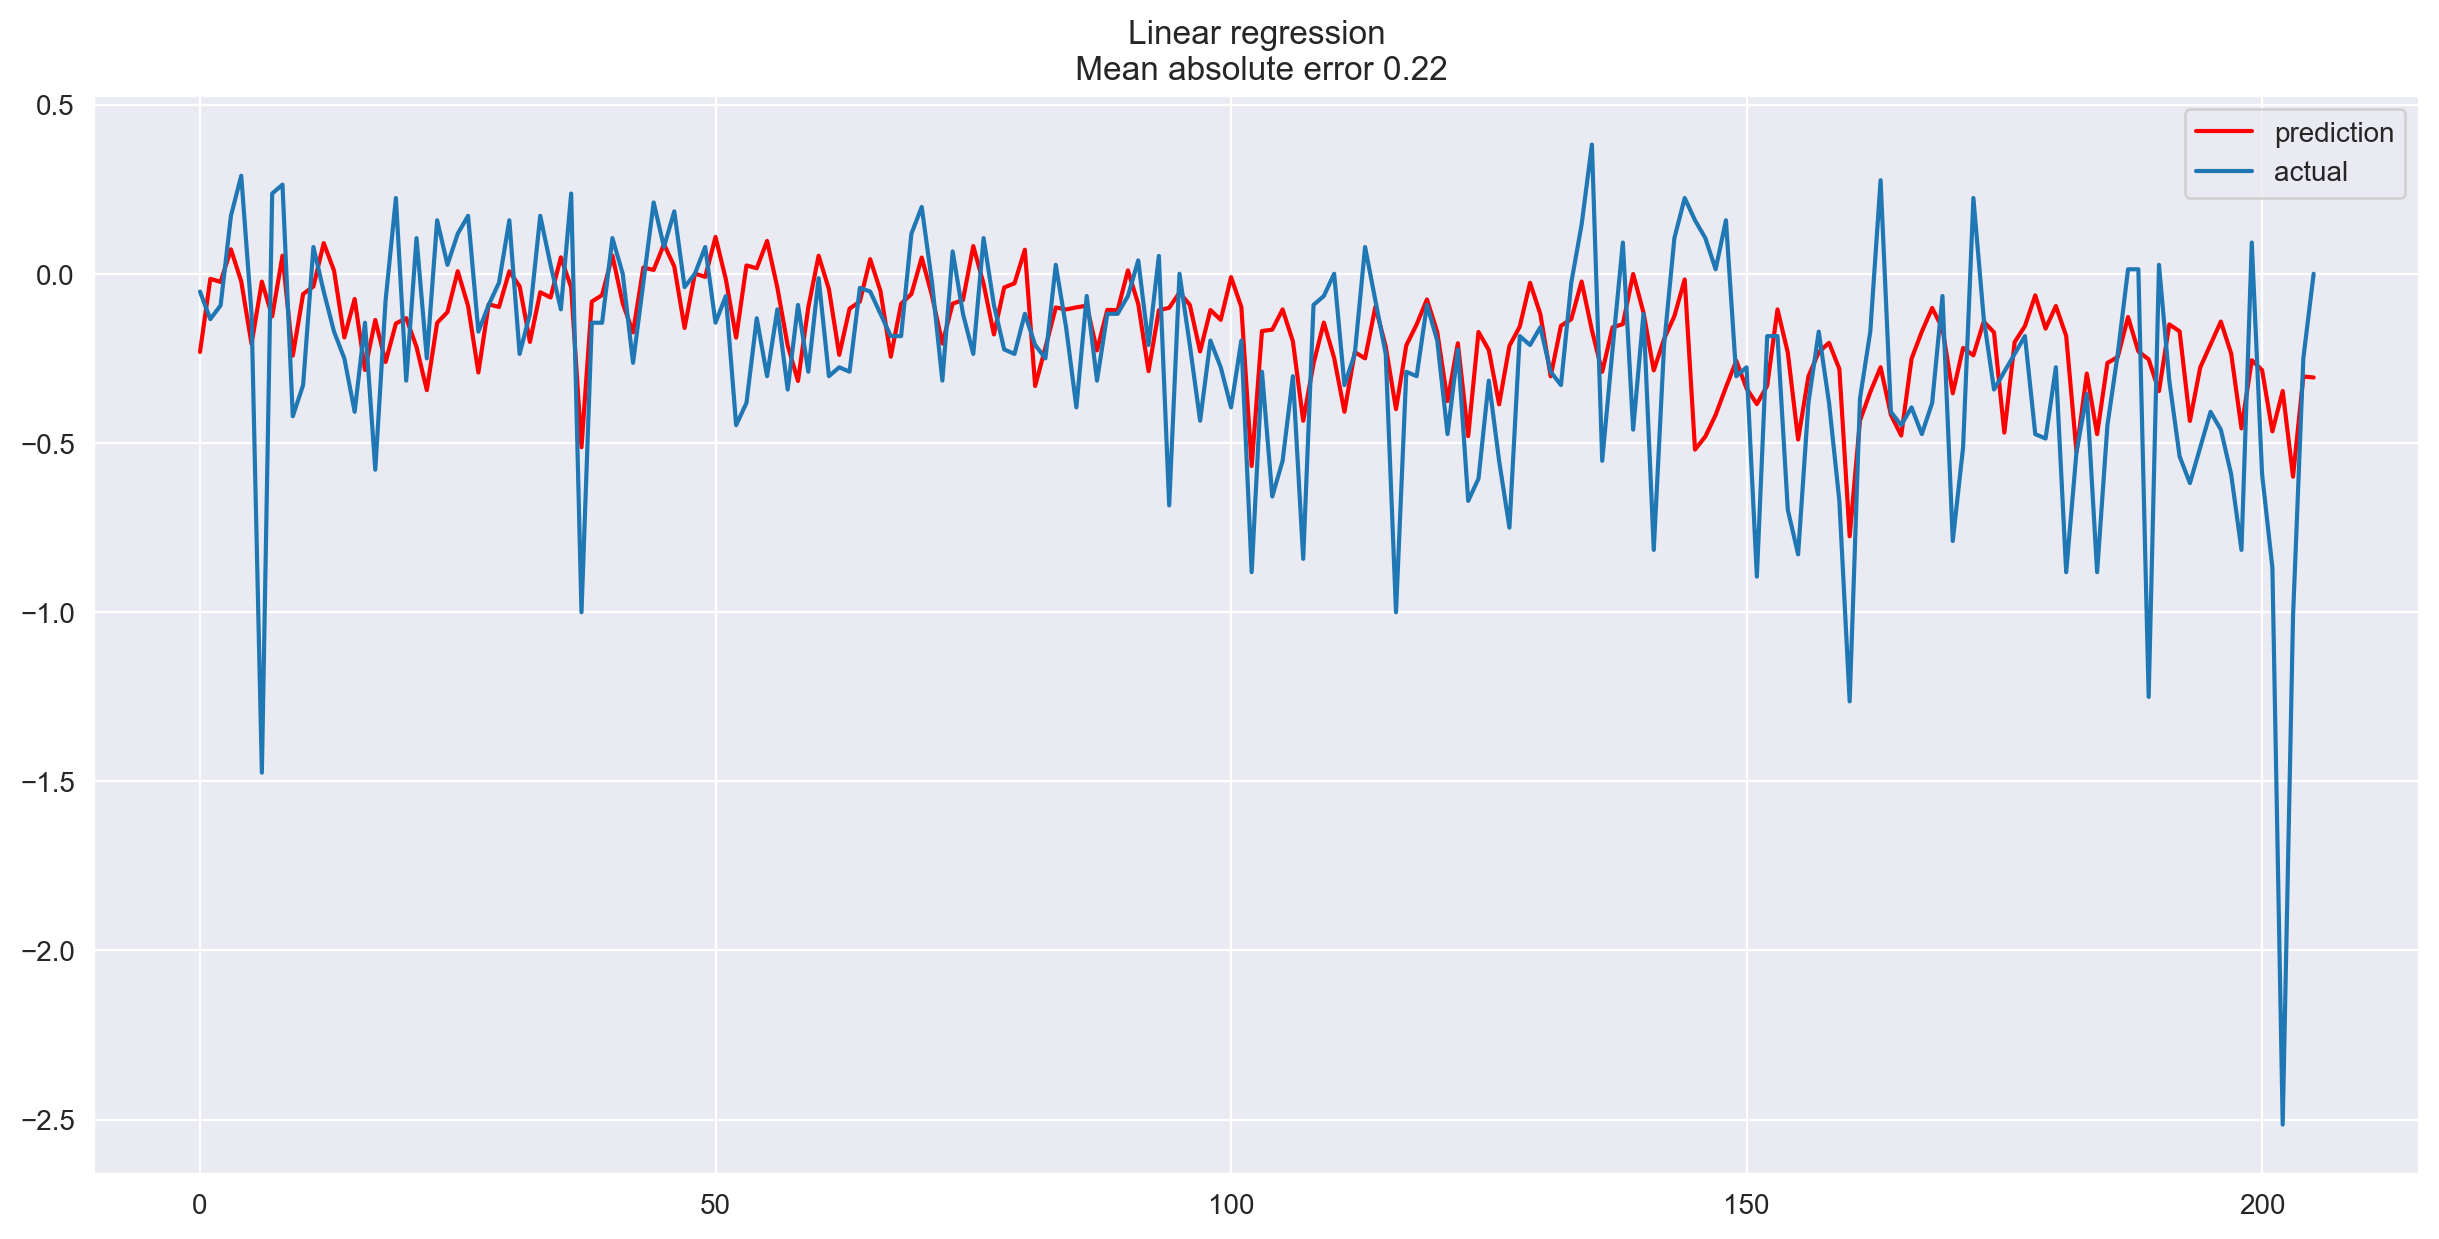

In [261]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
prediction = model.predict(X_test)
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Mean absolute error {}".format(round(mean_absolute_error(prediction, y_test), 2)))
plt.grid(True)

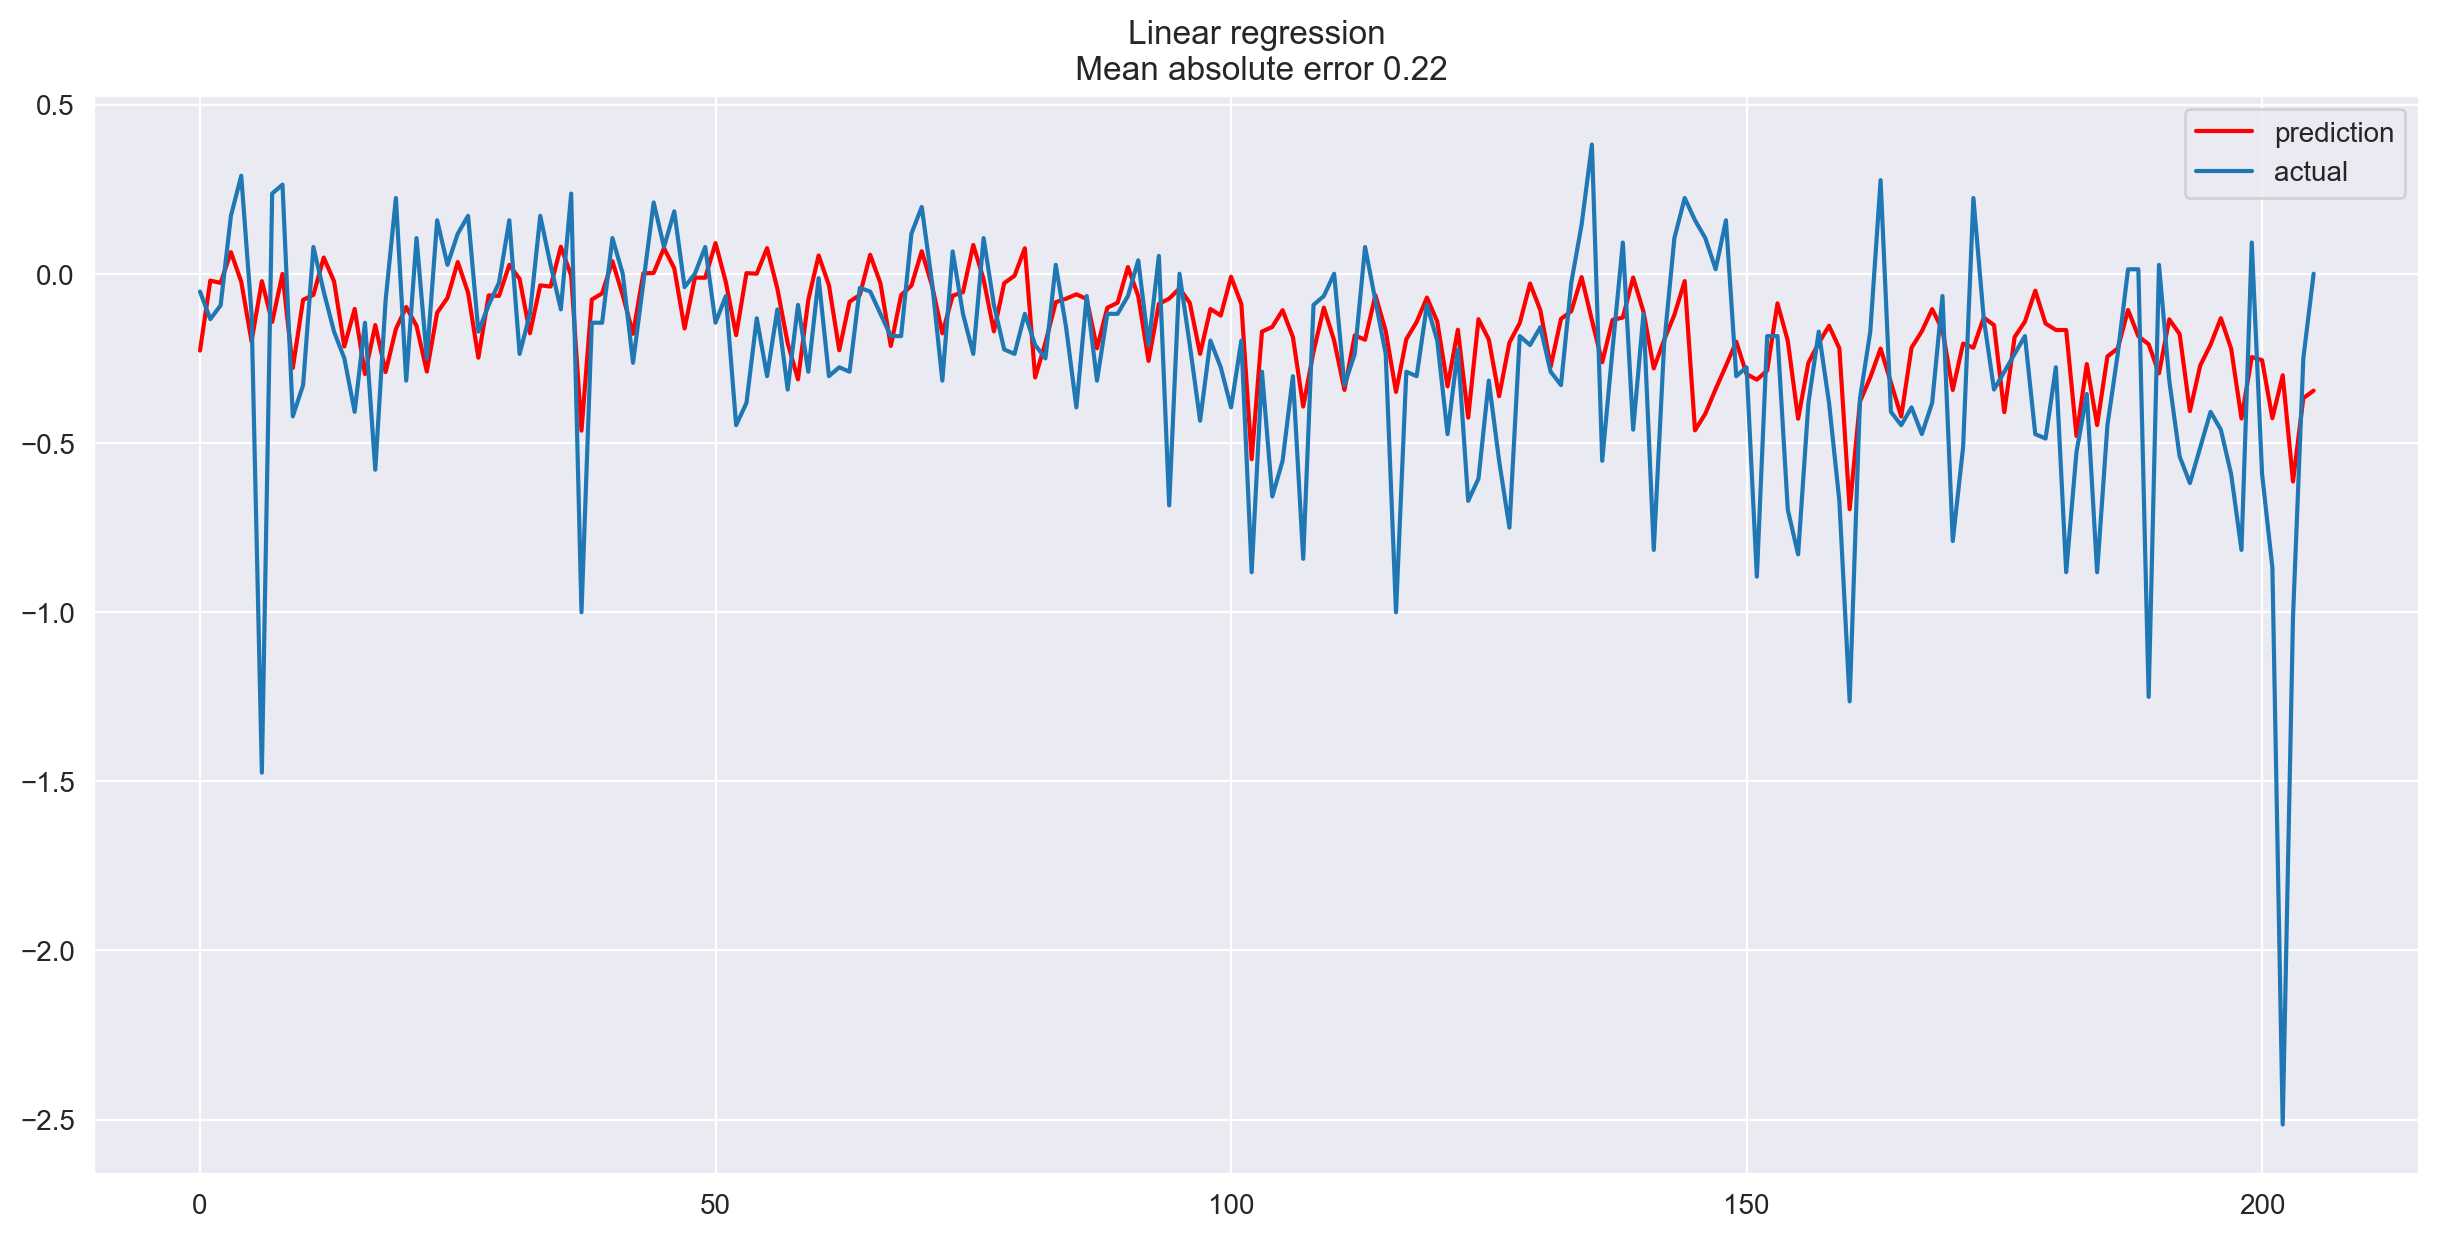

In [262]:
from sklearn.linear_model import Lasso

model = Lasso(alpha=0.001)
model.fit(X_train, y_train)
prediction = model.predict(X_test)
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Mean absolute error {}".format(round(mean_absolute_error(prediction, y_test), 2)))
plt.grid(True)

In [263]:
# отбор по лассо
X_test.columns[np.where(model.coef_ == 0)[0]]

Index(['rolling_mean_3', 'rolling_std_3', 'week_day_4', 'week_day_5',
       'month_2', 'month_3', 'month_6'],
      dtype='object')

In [264]:
from sklearn.feature_selection import SequentialFeatureSelector

model = LinearRegression()
sfs = SequentialFeatureSelector(model, direction='forward')
sfs.fit(X_train, y_train)

X_train = sfs.transform(X_train)
X_test = sfs.transform(X_test)
sfs.get_feature_names_out()

array(['tax_day', 'lag_outcome_1', 'rolling_mean_7', 'rolling_mean_14',
       'week_day_0', 'week_day_2', 'week_day_3', 'week_day_5', 'month_2',
       'month_4', 'month_5', 'month_8', 'month_11', 'month_12'],
      dtype=object)

In [269]:
dataset = dataset[list(sfs.get_feature_names_out()) + ['Balance']]
dataset.index = df.index[14:]

In [270]:
dataset.to_csv("../data/features_df.csv")

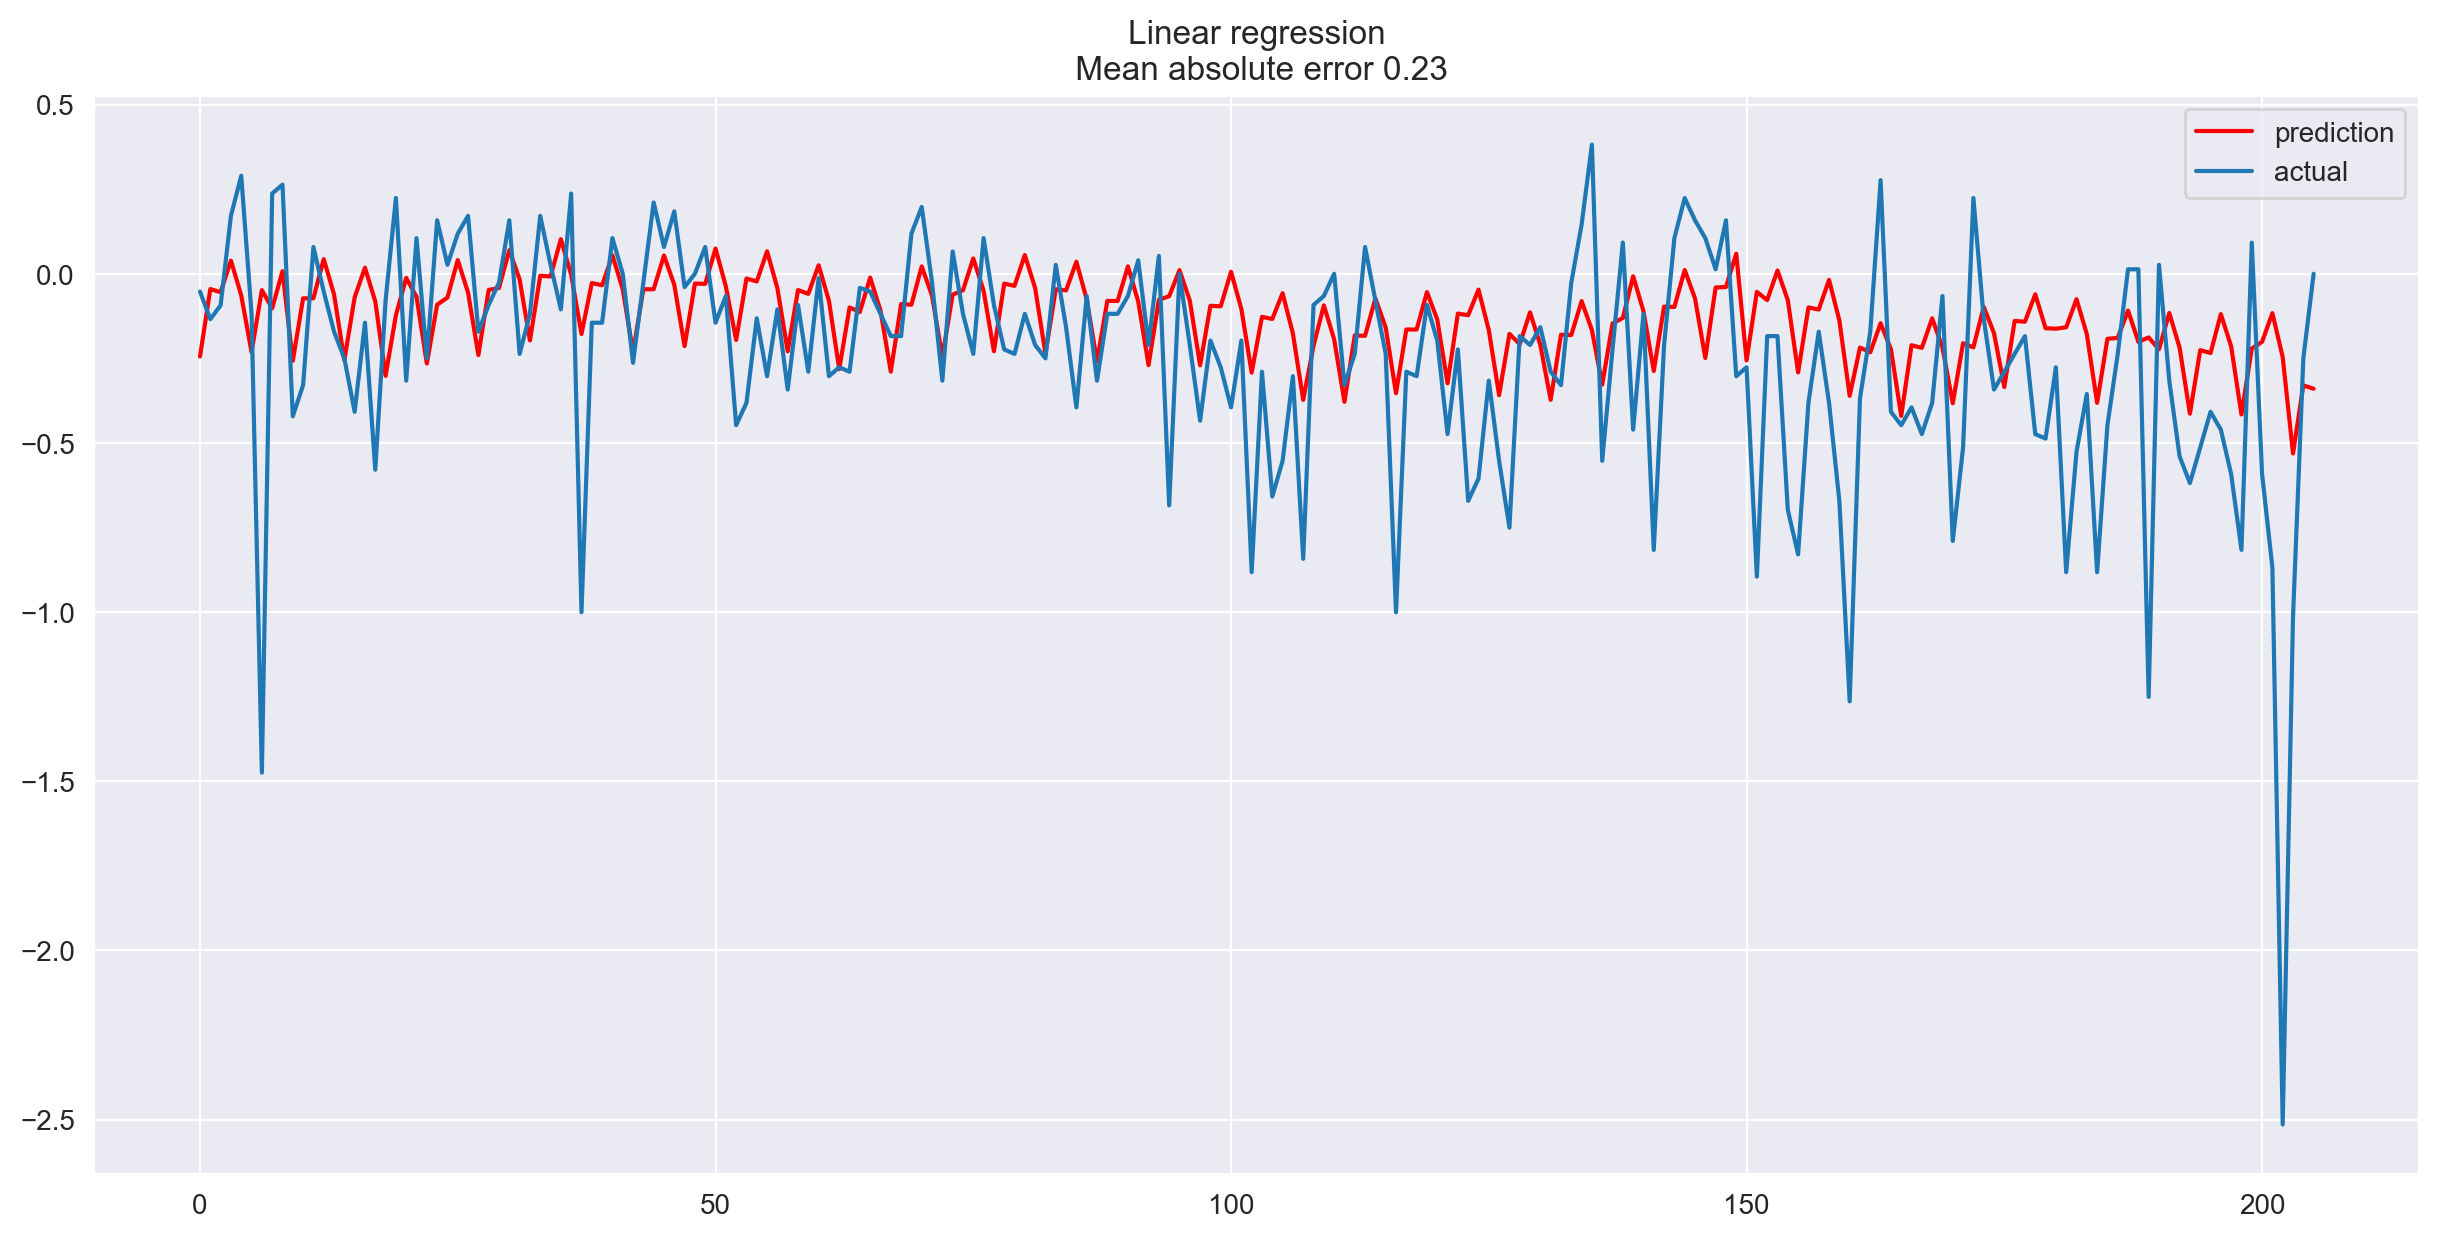

In [253]:
model = LinearRegression()
model.fit(X_train, y_train)
prediction = model.predict(X_test)
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Mean absolute error {}".format(round(mean_absolute_error(prediction, y_test), 2)))
plt.grid(True)

In [231]:
from sklearn.feature_selection import SequentialFeatureSelector

model = LinearRegression()
sfs = SequentialFeatureSelector(model, direction='backward')
sfs.fit(X_train, y_train)

X_train = sfs.transform(X_train)
X_test = sfs.transform(X_test)

In [232]:
sfs.get_feature_names_out()

array(['tax_day', 'rolling_std_3', 'rolling_mean_14', 'rolling_std_14',
       'week_day_0', 'week_day_1', 'week_day_2', 'week_day_3',
       'week_day_4', 'week_day_5', 'month_1', 'month_2', 'month_3',
       'month_8', 'month_11'], dtype=object)

In [242]:
dataset = dataset[list(sfs.get_feature_names_out()) + ['Balance']]
dataset

tax_day  rolling_std_3  rolling_mean_14  rolling_std_14  week_day_0  \
0           0       0.114356        -0.036247        0.282661           0   
1           0       0.044693        -0.040138        0.284638           1   
2           0       0.033019        -0.042439        0.285511           0   
3           0       0.089924        -0.044923        0.285192           0   
4           0       0.125590        -0.095174        0.159944           0   
...       ...            ...              ...             ...         ...   
1022        1       0.473339        -0.426045        0.374011           0   
1023        0       0.494827        -0.489058        0.368597           0   
1024        0       1.039299        -0.669633        0.630108           1   
1025        0       0.911314        -0.652704        0.616325           0   
1026        0       1.152189        -0.672455        0.597019           0   

      week_day_1  week_day_2  week_day_3  week_day_4  week_day_5  month_1  \
0              0           0           0           1           0        1   
1              0           0           0           0           0        1   
2              1           0           0           0           0        1   
3              0           1           0           0           0        0   
4              0           0           1           0           0        0   
...          ...         ...         ...         ...         ...      ...   
1022           0           0           1           0           0        0   
1023           0           0           0           1           0        0   
1024           0           0           0           0           0        0   
1025           1           0           0           0           0        0   
1026           0           1           0           0           0        0   

      month_2  month_3  month_8  month_11   Balance  
0           0        0        0         0 -0.199300  
1           0        0        0         0 -0.157799  
2           0        0        0         0 -0.027000  
3           1        0        0         0  0.093309  
4           1        0        0         0  0.083316  
...       ...      ...      ...       ...       ...  
1022        0        1        0         0 -0.869018  
1023        0        1        0         0 -2.514887  
1024        0        1        0         0 -1.013855  
1025        0        1        0         0 -0.250172  
1026        0        1        0         0  0.000000  

[1027 rows x 16 columns]

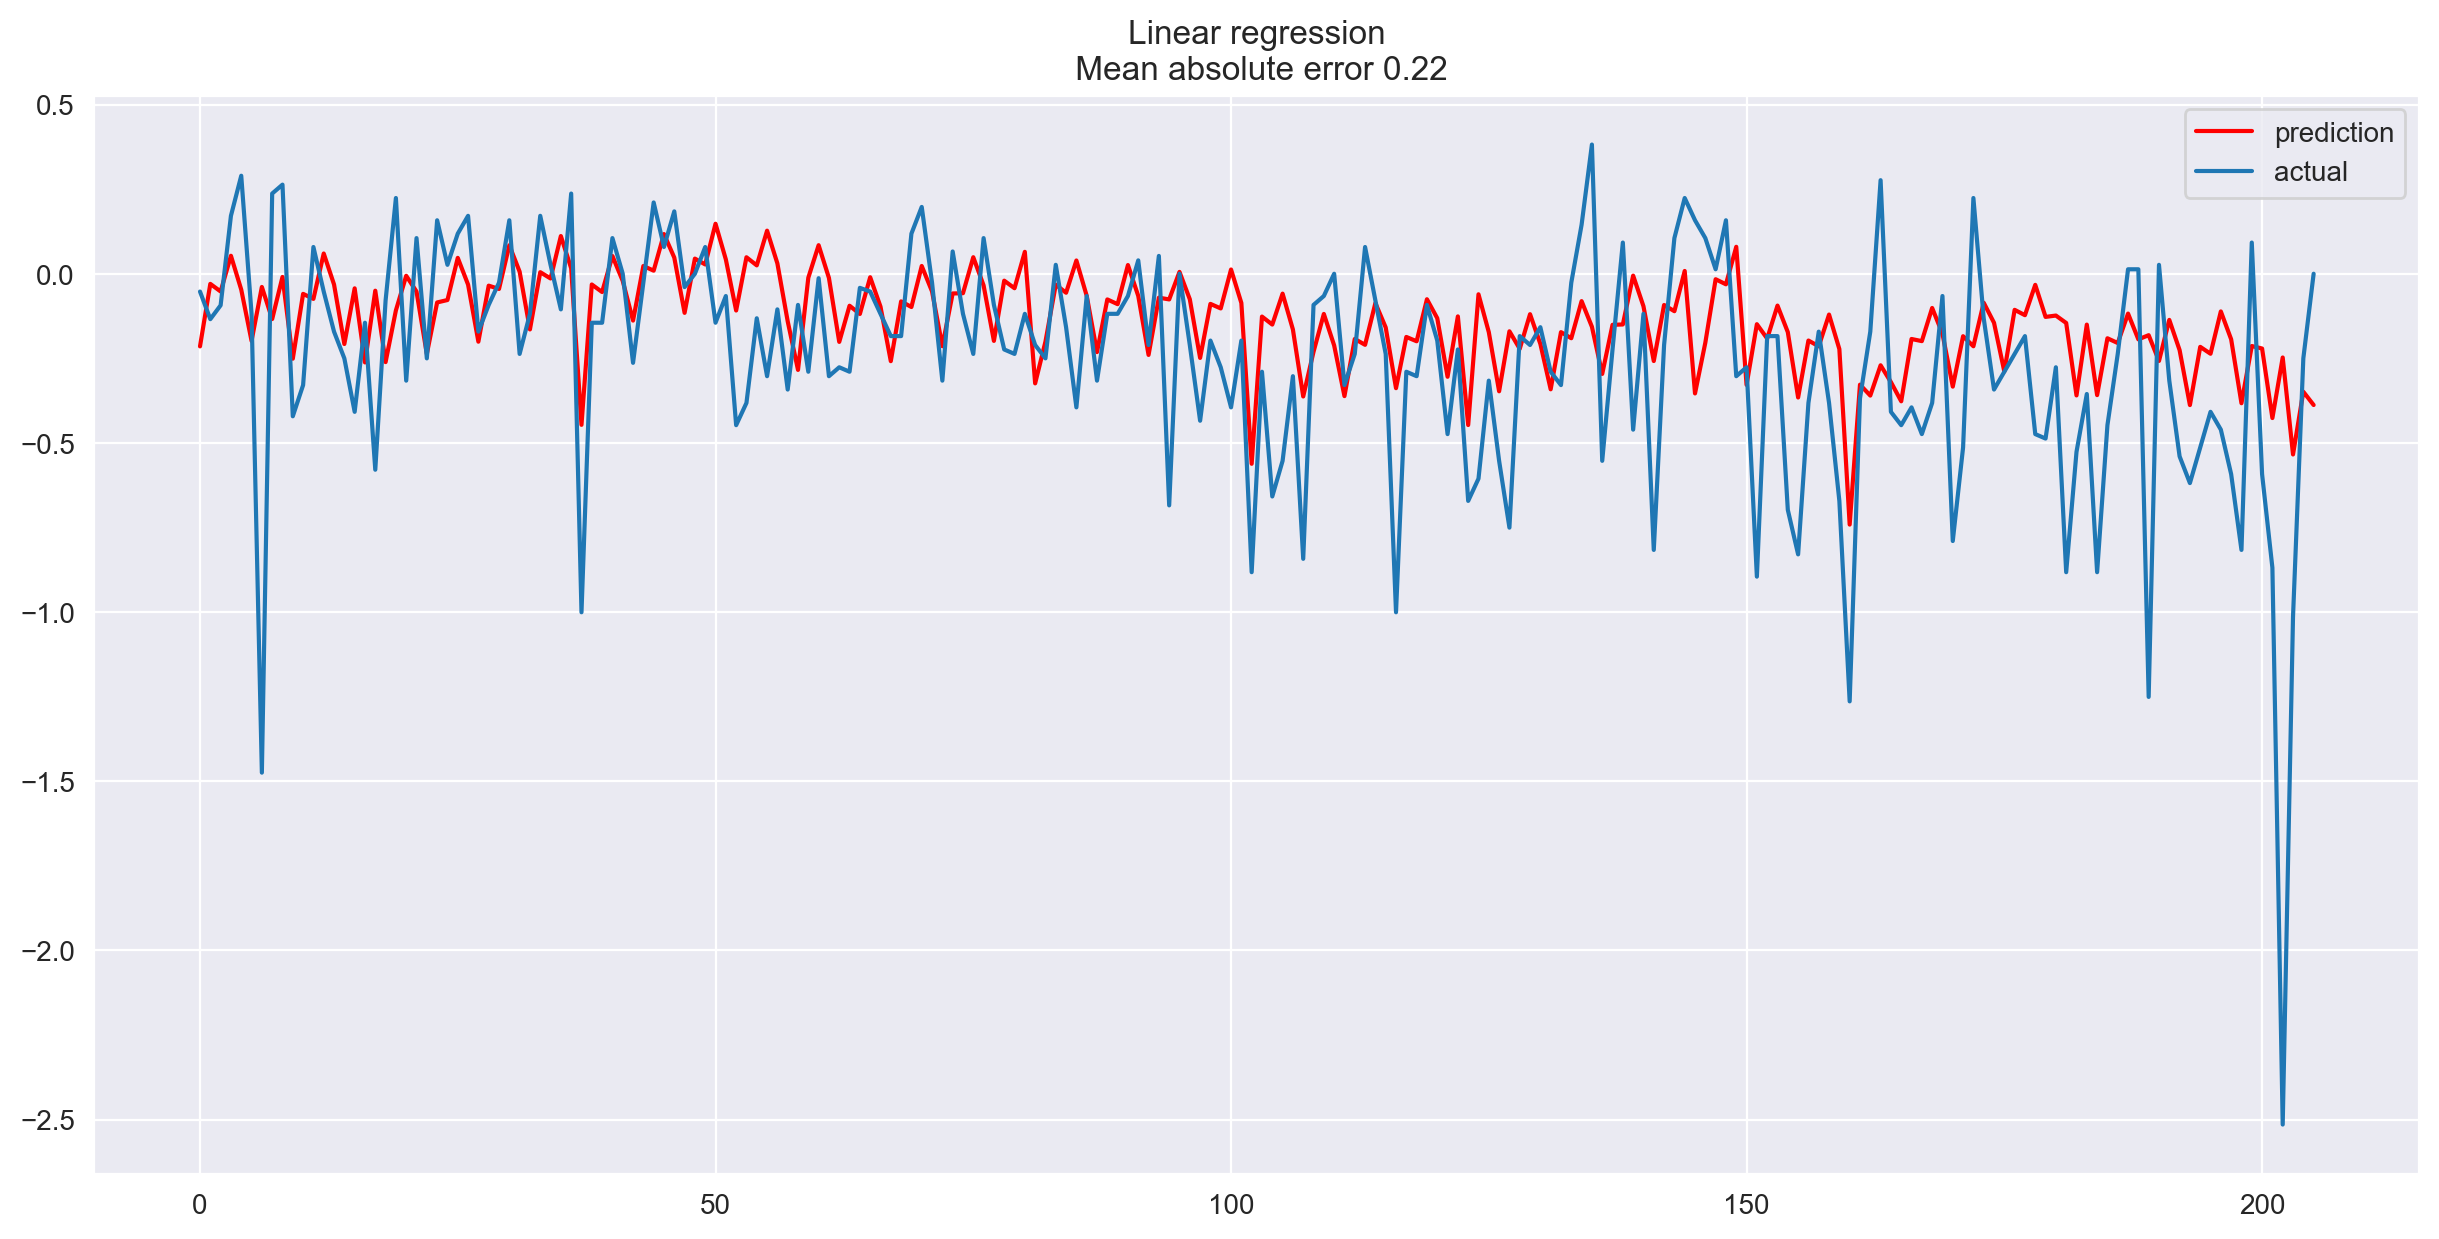

In [233]:
model = LinearRegression()
model.fit(X_train, y_train)
prediction = model.predict(X_test)
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Mean absolute error {}".format(round(mean_absolute_error(prediction, y_test), 2)))
plt.grid(True)

In [238]:
import xgboost as xgb

def XGB_forecast(data, lags, test_size, scale=1.96):
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)
    
    # задаём параметры
    params = {
        'objective': 'reg:linear',
        'booster':'gblinear'
    }
    trees = 100
    
    # прогоняем на кросс-валидации с метрикой rmse
    cv = xgb.cv(params, dtrain, metrics = ('rmse'), verbose_eval=False, nfold=10, show_stdv=False, num_boost_round=trees)
    
    # обучаем xgboost с оптимальным числом деревьев, подобранным на кросс-валидации
    bst = xgb.train(params, dtrain, num_boost_round=cv['test-rmse-mean'].argmin())
    
    # можно построить кривые валидации
    #cv.plot(y=['test-mae-mean', 'train-mae-mean'])
    
    # запоминаем ошибку на кросс-валидации
    deviation = cv.loc[cv['test-rmse-mean'].argmin()]["test-rmse-mean"]
    
    # посмотрим, как модель вела себя на тренировочном отрезке ряда
    prediction_train = bst.predict(dtrain)
    plt.figure(figsize=(15, 5))
    plt.plot(prediction_train)
    plt.plot(y_train)
    plt.axis('tight')
    plt.grid(True)
    
    # и на тестовом
    prediction_test = bst.predict(dtest)
    lower = prediction_test-scale*deviation
    upper = prediction_test+scale*deviation

    Anomalies = np.array([np.nan]*len(y_test))
    Anomalies[y_test<lower] = y_test[y_test<lower]

    plt.figure(figsize=(15, 5))
    plt.plot(prediction_test, label="prediction")
    plt.plot(lower, "r--", label="upper bond / lower bond")
    plt.plot(upper, "r--")
    plt.plot(list(y_test), label="y_test")
    plt.plot(Anomalies, "ro", markersize=10)
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("XGBoost Mean absolute error {}".format(round(mean_absolute_error(prediction_test, y_test), 2)))
    plt.grid(True)
    plt.legend()

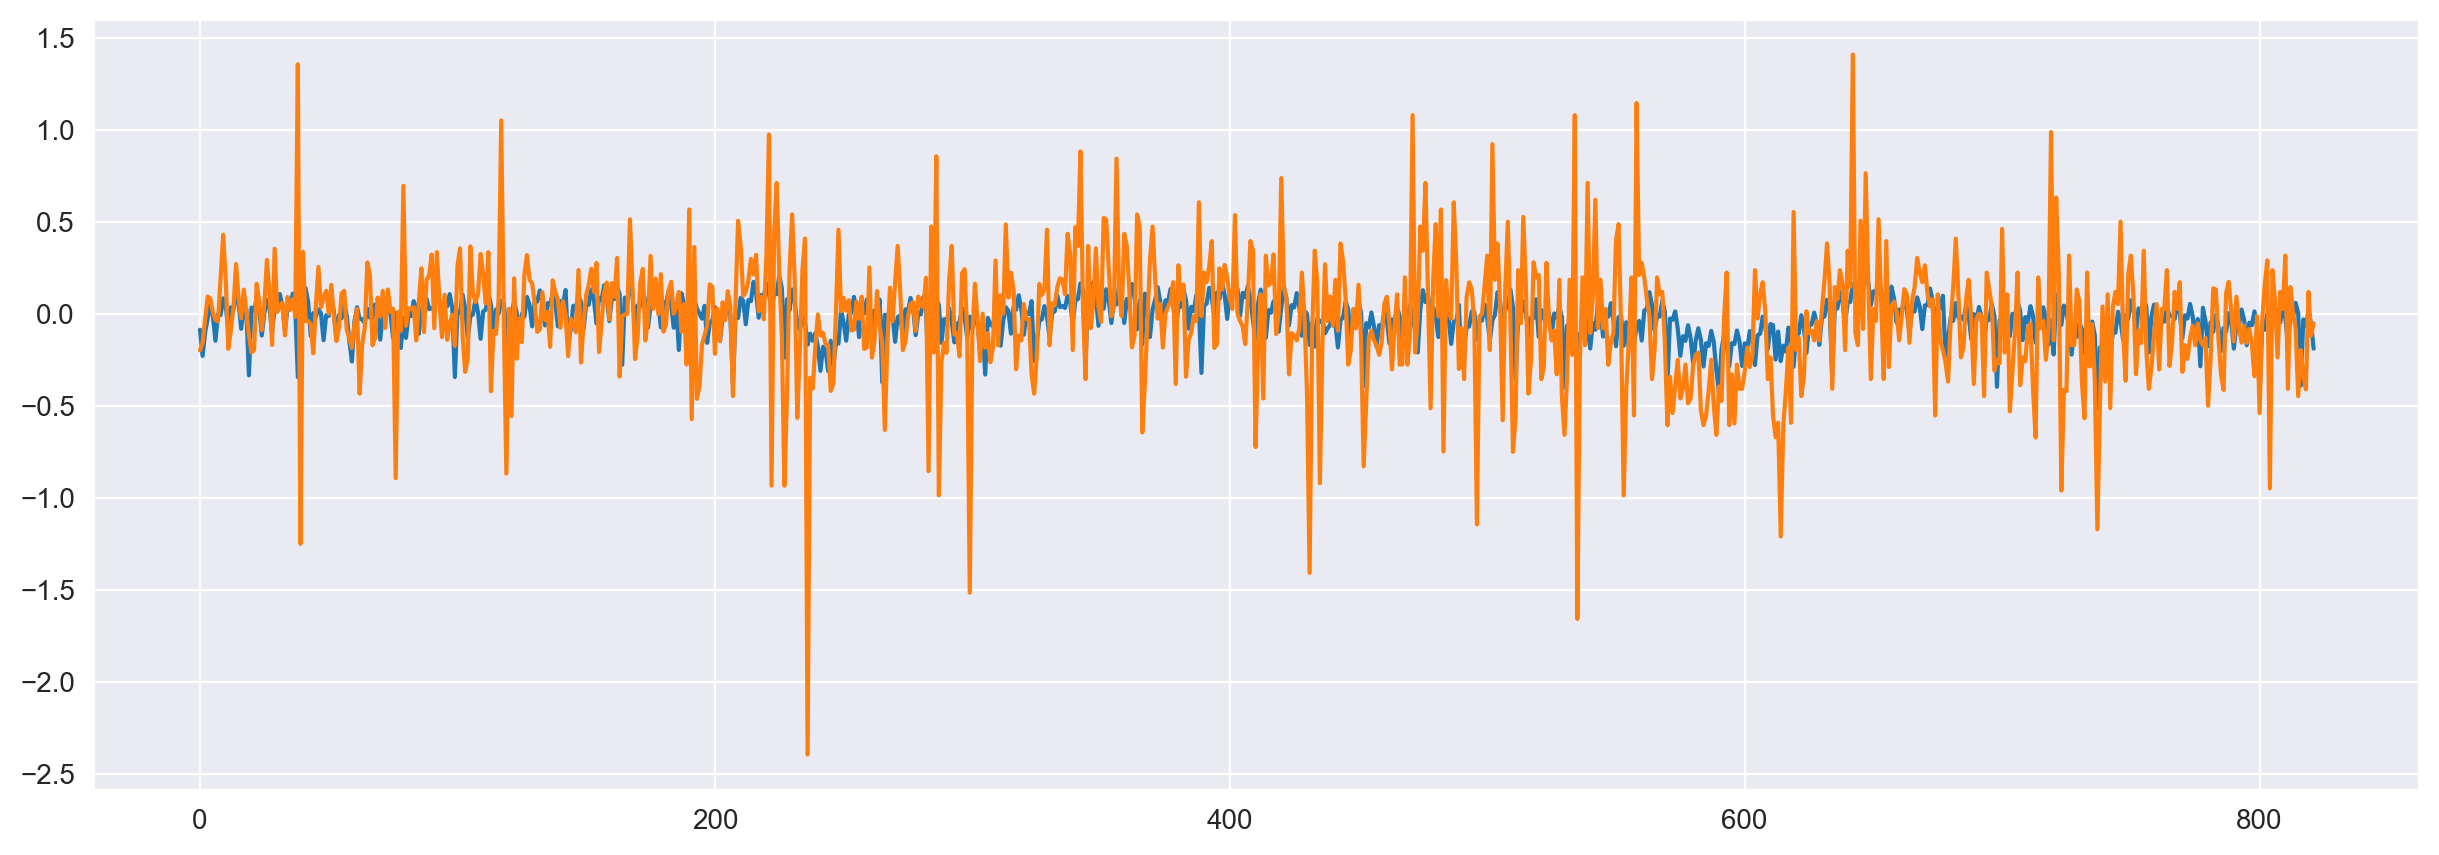

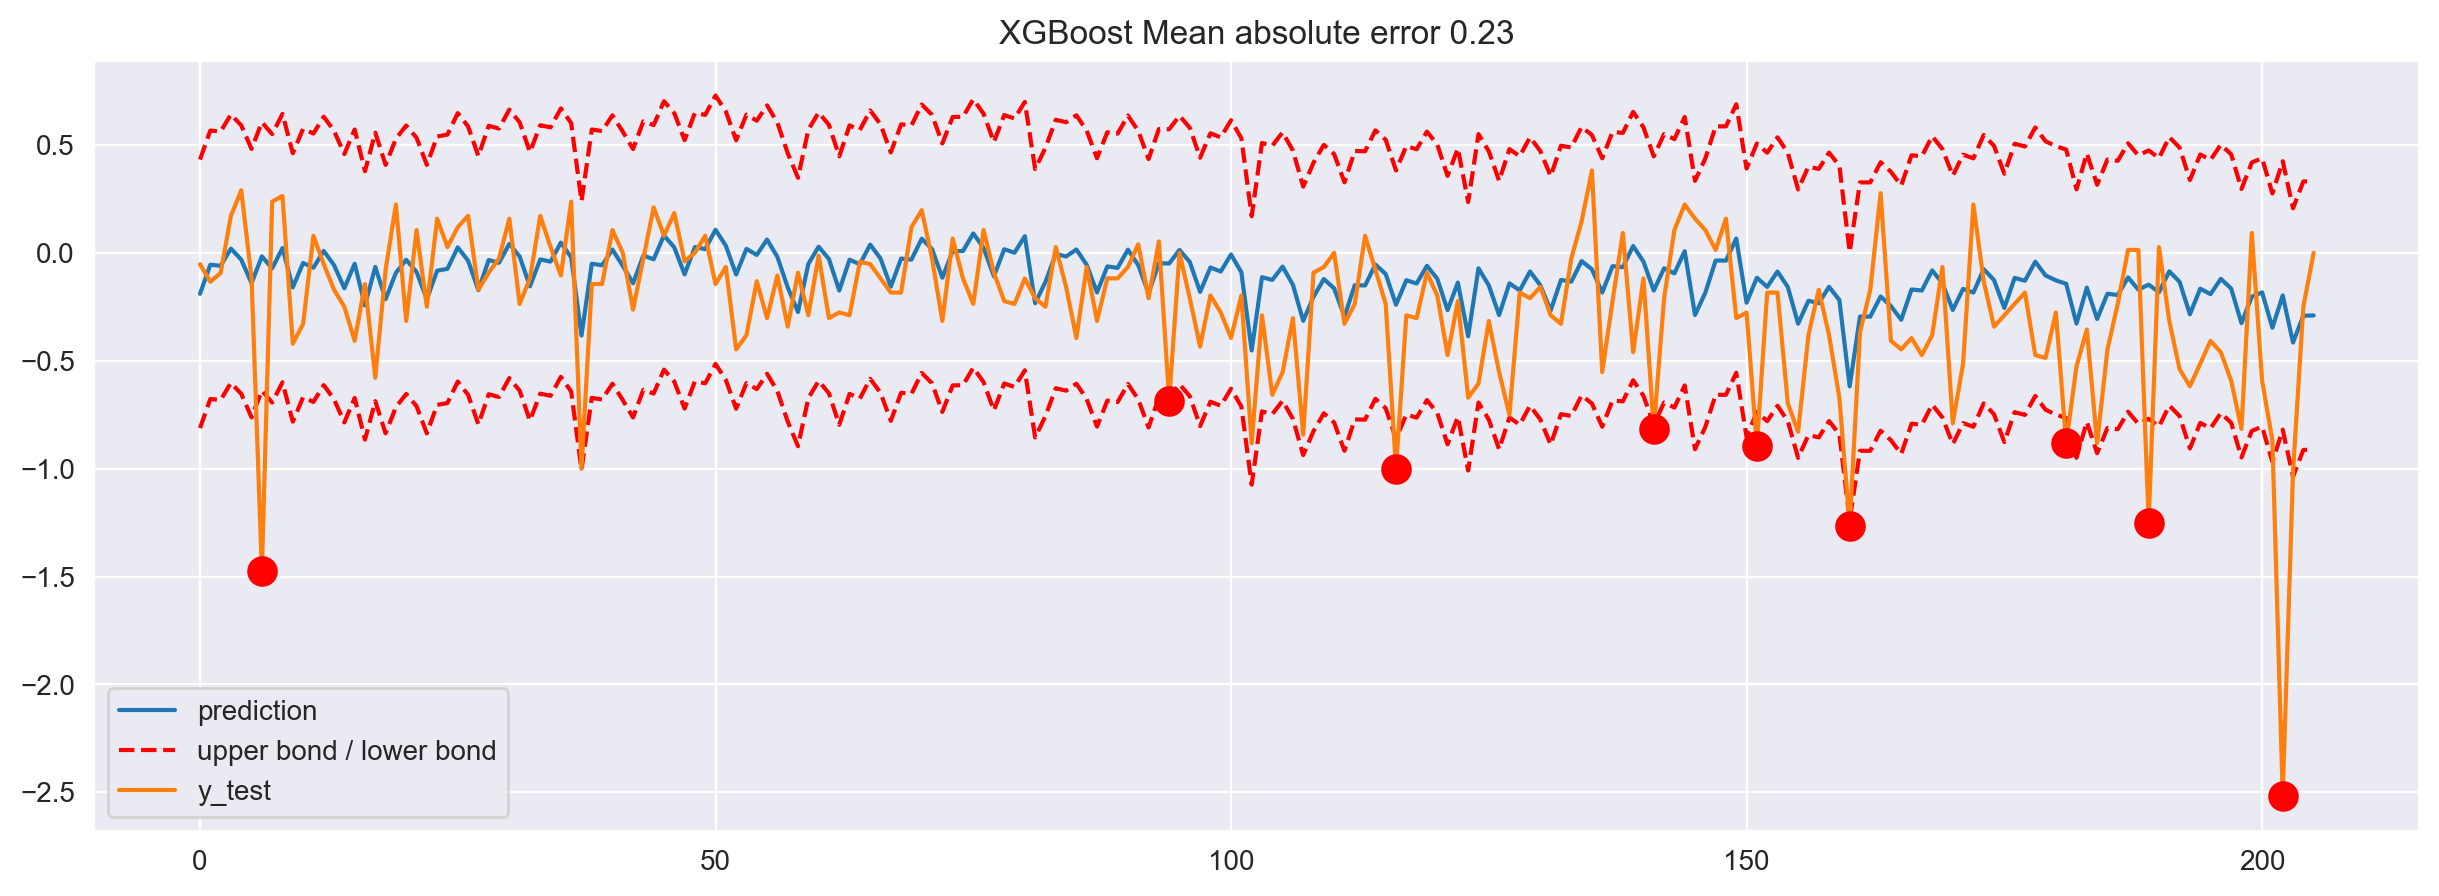

In [239]:
XGB_forecast(dataset, test_size=0.2, lags=range(1, 10))